<a href="https://colab.research.google.com/github/ryanzhangofficial/basketball_tournament_predictions/blob/main/code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade scikit-learn

In [ ]:
!pip install -U scikit-learn xgboost


In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import torch

In [ ]:
np.int = int

# Preprocessing

In [ ]:
team_regions = pd.read_csv("Team Region Groups - Sheet1.csv")
data_dict = pd.read_csv("DataDictionary - Sheet1.csv")
regional_games = pd.read_csv("East Regional Games to predict - Sheet1.csv")
pd.set_option('display.max_columns', None)
games_2022 = pd.read_csv('games_2022 (edited).csv')
games_2022

,game_id,game_date,team,FGA_2,FGM_2,FGA_3,FGM_3,FTA,FTM,AST,BLK,STL,TOV,TOV_team,DREB,OREB,F_tech,F_personal,team_score,opponent_team_score,largest_lead,OT_length_min_tot,rest_days,attendance,tz_dif_H_E,prev_game_dist,home_away_NS,travel_dist,home_away
0,game_2022_2011,2021-12-30,georgia_lady_bulldogs,50,22,11,5,6,3,14,7,7,18,0,25,11,0,18,62,68,1,0,9,3241.0,0,0,1,0,home
1,game_2022_2011,2021-12-30,lsu_tigers,50,24,11,4,15,8,15,2,15,14,2,25,11,0,7,68,62,14,0,3,3241.0,0,824,-1,824,home
2,game_2022_2012,2021-12-30,missouri_tigers,43,18,15,7,16,13,10,1,4,8,1,31,6,0,11,70,69,8,5,8,6139.0,0,371,1,0,away
3,game_2022_2012,2021-12-30,south_carolina_gamecocks,55,23,21,6,9,5,15,8,3,8,0,27,20,0,15,69,70,6,5,9,6139.0,0,1154,-1,1154,home
4,game_2022_2013,2021-12-30,tennessee_lady_volunteers,41,20,15,4,15,10,16,8,5,15,1,34,12,0,13,62,44,19,0,3,8124.0,0,0,1,0,home
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9821,game_2022_4795,2022-03-01,xavier_musketeers,44,19,12,2,12,9,15,3,4,10,0,25,8,0,12,53,74,0,0,2,156.0,0,0,1,0,home
9822,game_2022_4968,2022-03-04,harvard_crimson,30,19,39,15,10,2,20,2,13,6,0,28,10,0,8,85,52,40,0,13,373.0,0,378,-1,173,home
9823,game_2022_4968,2022-03-04,dartmouth_big_green,32,15,26,6,7,4,7,1,4,21,2,29,10,0,8,52,85,3,0,6,373.0,0,479,1,0,home
9824,game_2022_5067,2022-03-06,harvard_crimson,38,13,35,6,10,9,11,3,7,11,0,23,18,0,20,53,73,0,0,2,757.0,0,173,1,0,home


In [ ]:
games_2022['team'].nunique()

355

In [ ]:
a = games_2022[games_2022['team'] == 'georgia_lady_bulldogs']
a.reset_index()

,index,game_id,game_date,team,FGA_2,FGM_2,FGA_3,FGM_3,FTA,FTM,AST,BLK,STL,TOV,TOV_team,DREB,OREB,F_tech,F_personal,team_score,opponent_team_score,largest_lead,OT_length_min_tot,rest_days,attendance,tz_dif_H_E,prev_game_dist,home_away_NS,travel_dist,home_away
0,0,game_2022_2011,2021-12-30,georgia_lady_bulldogs,50,22,11,5,6,3,14,7,7,18,0,25,11,0,18,62,68,1,0,9,3241.0,0,0,1,0,home
1,11,game_2022_2113,2022-01-02,georgia_lady_bulldogs,56,26,6,1,23,18,10,2,15,17,2,19,16,0,15,73,69,4,0,3,1119.0,0,484,-1,484,home
2,18,game_2022_2191,2022-01-06,georgia_lady_bulldogs,50,26,10,2,20,18,15,4,8,19,1,26,12,0,14,76,84,6,0,4,3013.0,0,948,-1,464,home
3,33,game_2022_2315,2022-01-09,georgia_lady_bulldogs,49,27,10,3,11,9,21,8,10,16,0,24,12,0,14,72,68,4,0,3,3453.0,0,464,1,0,home
4,65,game_2022_2651,2022-01-17,georgia_lady_bulldogs,53,22,8,4,19,16,16,4,7,10,0,22,11,0,19,72,62,14,0,8,3752.0,0,973,-1,973,home
5,71,game_2022_2748,2022-01-20,georgia_lady_bulldogs,57,25,4,2,12,10,14,6,2,16,1,33,17,0,11,66,63,27,0,3,4961.0,0,686,-1,506,home
6,81,game_2022_2956,2022-01-23,georgia_lady_bulldogs,53,18,15,4,10,7,17,8,10,18,0,22,19,0,16,55,63,9,0,3,5117.0,0,506,1,0,home
7,103,game_2022_3306,2022-01-30,georgia_lady_bulldogs,45,23,9,3,12,7,16,2,6,19,0,33,7,0,14,62,52,17,0,7,3333.0,0,567,-1,567,home
8,115,game_2022_3419,2022-02-03,georgia_lady_bulldogs,46,29,16,2,10,7,23,7,11,21,2,26,13,0,11,71,56,16,0,4,2254.0,0,567,1,0,home
9,123,game_2022_3639,2022-02-06,georgia_lady_bulldogs,54,21,10,1,7,6,12,5,12,11,0,27,8,0,12,51,54,7,0,3,3653.0,0,0,1,0,home


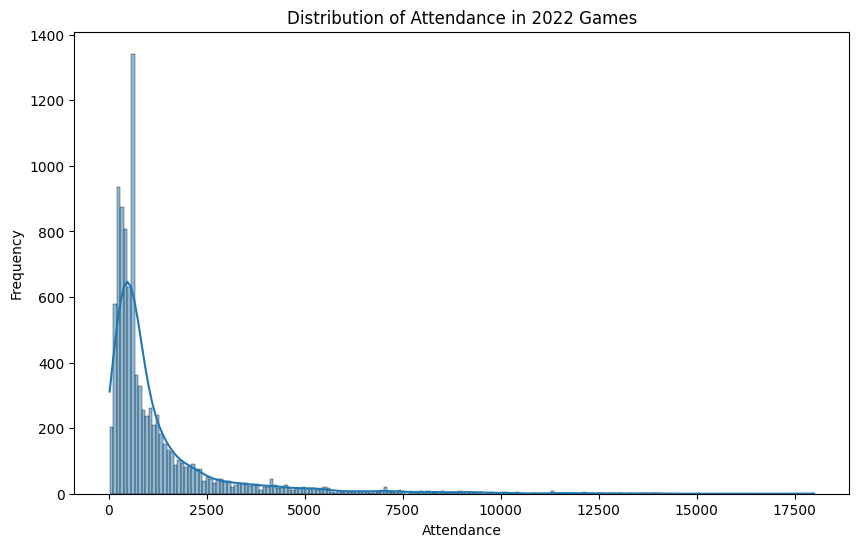

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(games_2022["attendance"], kde=True)
plt.title("Distribution of Attendance in 2022 Games")
plt.xlabel("Attendance")
plt.ylabel("Frequency")
plt.show()

In [ ]:
#log normalize

columns_to_transform = [
    'BLK',
    'TOV_team',
    'largest_lead',
    'rest_days',
    'attendance',
    'travel_dist',
    'prev_game_dist'
]

# Apply the log1p transformation to the specified columns
for col in columns_to_transform:
    games_2022[col] = np.log1p(games_2022[col])

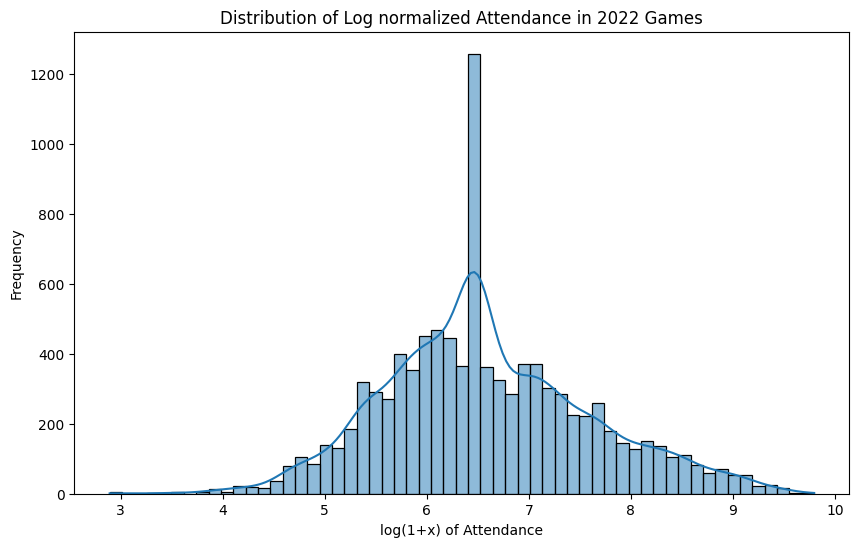

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(games_2022["attendance"], kde=True)
plt.title("Distribution of Log normalized Attendance in 2022 Games")
plt.xlabel("log(1+x) of Attendance")
plt.ylabel("Frequency")
plt.show()

In [ ]:
#normalize between 0 and 1

columns_to_normalize = [
    'AST',
    'BLK',
    'STL',
    'TOV',
    'TOV_team',
    'DREB',
    'OREB',
    'F_personal',
    'F_tech',
    'team_score',
    'opponent_team_score',
    'OT_length_min_tot',
    'largest_lead',
    'rest_days',
    'attendance',
    'tz_dif_H_E',
    'prev_game_dist',
    'travel_dist']

scaler = MinMaxScaler(feature_range=(0, 1))
games_2022[columns_to_normalize] = scaler.fit_transform(games_2022[columns_to_normalize])

In [ ]:
games_2022["fg_pct_2"] = games_2022["FGM_2"] / games_2022["FGA_2"]
games_2022["fg_pct_3"] = games_2022["FGM_3"] / games_2022["FGA_3"]
games_2022["ft_pct"] = games_2022["FTM"] / games_2022["FTA"]

In [ ]:
games_2022["point_diff"] = games_2022["team_score"] - games_2022["opponent_team_score"]

games_2022["win"] = (games_2022["team_score"] > games_2022["opponent_team_score"]).astype(int)

In [ ]:
team_agg = games_2022.groupby("team").agg({
    "win": ["mean", "sum"],
    "team_score": "mean",
    "opponent_team_score": "mean",
    "fg_pct_2": "mean",
    "fg_pct_3": "mean",
    "ft_pct": "mean",
    "AST": "mean",
    "BLK": "mean",
    "STL": "mean",
    "TOV": "mean",
    "TOV_team": "mean",
    "DREB": "mean",
    "OREB": "mean",
    "F_personal": "mean",
    "F_tech": "mean",
    "OT_length_min_tot": "mean",
    "largest_lead": "mean",
    "rest_days": "mean",
    "attendance": "mean",
    "tz_dif_H_E": "mean",
    "prev_game_dist": "mean",
    "travel_dist": "mean",
    "point_diff": "mean"
})

In [ ]:
team_agg.columns = ["_".join(col).strip() for col in team_agg.columns.values]
team_agg = team_agg.reset_index()
team_agg.rename(columns={"win_mean": "win_percentage", "win_sum": "total_wins"}, inplace=True)
team_agg = team_agg.merge(team_regions, on="team", how="left")

In [ ]:
all_teams = pd.concat([games_2022["team"], games_2022["team"]]).unique()
elo_ratings = {team: 1500 for team in all_teams}

In [ ]:
def expected_score(rating_a, rating_b):
    """Calculate expected score for team A against team B."""
    return 1 / (1 + 10 ** ((rating_b - rating_a) / 400))

In [ ]:
grouped_games = games_2022.groupby("game_id")
k = 20

In [ ]:
for game_id, group in grouped_games:
    if group.shape[0] != 2:
        continue
    if "home" in group["home_away"].values and "away" in group["home_away"].values:
        home_row = group[group["home_away"] == "home"].iloc[0]
        away_row = group[group["home_away"] == "away"].iloc[0]
    else:
        home_row = group.iloc[0]
        away_row = group.iloc[1]

    home_team = home_row["team"]
    away_team = away_row["team"]
    home_score = home_row["team_score"]
    away_score = away_row["team_score"]

    outcome_home = 1 if home_score > away_score else 0
    outcome_away = 1 - outcome_home

    expected_home = expected_score(elo_ratings[home_team], elo_ratings[away_team])
    expected_away = expected_score(elo_ratings[away_team], elo_ratings[home_team])

    elo_ratings[home_team] += k * (outcome_home - expected_home)
    elo_ratings[away_team] += k * (outcome_away - expected_away)

In [ ]:
team_agg["elo_rating"] = team_agg["team"].apply(lambda t: elo_ratings.get(t, 1500))

In [ ]:
regional_games["elo_home"] = regional_games["team_home"].apply(lambda t: elo_ratings.get(t, 1500))
regional_games["elo_away"] = regional_games["team_away"].apply(lambda t: elo_ratings.get(t, 1500))
regional_games["expected_home"] = 1 / (1 + 10 ** ((regional_games["elo_away"] - regional_games["elo_home"]) / 400))
regional_games["predicted_winning_%_elo"] = regional_games["expected_home"]

In [ ]:
team_agg["combined_rank_score"] = team_agg["win_percentage"] * 0.5 + (team_agg["elo_rating"] / 3000) * 0.5
team_agg.sort_values("combined_rank_score", ascending=False, inplace=True)

In [ ]:
games_home = games_2022[games_2022["home_away"] == "home"][["game_id", "team", "win"]].rename(columns={"team": "team_home", "win": "win_home"})
games_away = games_2022[games_2022["home_away"] == "away"][["game_id", "team", "win"]].rename(columns={"team": "team_away", "win": "win_away"})

In [ ]:
team_agg

,team,win_percentage,total_wins,team_score_mean,opponent_team_score_mean,fg_pct_2_mean,fg_pct_3_mean,ft_pct_mean,AST_mean,BLK_mean,STL_mean,TOV_mean,TOV_team_mean,DREB_mean,OREB_mean,F_personal_mean,F_tech_mean,OT_length_min_tot_mean,largest_lead_mean,rest_days_mean,attendance_mean,tz_dif_H_E_mean,prev_game_dist_mean,travel_dist_mean,point_diff_mean,region,elo_rating,combined_rank_score
262,south_carolina_gamecocks,0.935484,29,0.441966,0.258667,0.476529,0.315578,0.676142,0.366487,0.712499,0.232975,0.308419,0.202061,0.563275,0.521169,0.312175,0.000000,0.010753,0.683199,0.394258,0.831776,0.467742,0.496808,0.408745,0.183298,North,1707.349408,0.752300
85,florida_gulf_coast_eagles,0.923077,24,0.485262,0.322070,0.574094,0.333584,0.643437,0.439103,0.474550,0.353276,0.224203,0.278662,0.420118,0.268029,0.357320,0.000000,0.000000,0.659617,0.410602,0.560688,0.500000,0.508339,0.371911,0.163192,North,1671.877632,0.740185
182,nc_state_wolfpack,0.906250,29,0.489486,0.308703,0.508094,0.367841,0.767493,0.368056,0.418930,0.269676,0.250762,0.068680,0.542468,0.375000,0.296371,0.018750,0.020833,0.652206,0.387569,0.747550,0.479167,0.403998,0.304096,0.180783,NaN,1710.561783,0.738219
278,stanford_cardinal,0.903226,28,0.465179,0.307205,0.500605,0.358444,0.673766,0.392473,0.631627,0.318996,0.268293,0.192523,0.491315,0.417339,0.386056,0.000000,0.000000,0.640675,0.378475,0.673757,0.483871,0.415306,0.420103,0.157974,West,1699.737450,0.734902
307,ucf_knights,0.888889,24,0.342679,0.219453,0.438113,0.307366,0.701903,0.349794,0.462390,0.417010,0.334237,0.268341,0.376068,0.429398,0.311828,0.007407,0.000000,0.580225,0.417590,0.611184,0.456790,0.575950,0.440928,0.123226,North,1668.665847,0.722555
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,detroit_mercy_titans,0.037037,1,0.292835,0.418830,0.407079,0.262656,0.655214,0.276749,0.373759,0.334705,0.433604,0.181466,0.385565,0.358796,0.446834,0.014815,0.012346,0.208712,0.398821,0.416309,0.500000,0.417984,0.315842,-0.125995,NaN,1319.290953,0.238400
31,butler_bulldogs,0.035714,1,0.295060,0.503672,0.474366,0.261624,0.689546,0.288690,0.310307,0.182540,0.435540,0.296922,0.386447,0.290179,0.335253,0.000000,0.035714,0.203671,0.403987,0.516992,0.500000,0.413786,0.255909,-0.208611,NaN,1318.480270,0.237604
311,ul_monroe_warhawks,0.000000,0,0.304163,0.461342,0.386973,0.231866,0.669633,0.241162,0.394936,0.306397,0.385809,0.295437,0.334499,0.403409,0.486804,0.027273,0.015152,0.227693,0.426300,0.493391,0.492424,0.459042,0.315611,-0.157179,NaN,1331.890491,0.221982
64,delaware_state_hornets,0.000000,0,0.209856,0.490229,0.386449,0.233655,0.659957,0.188131,0.256635,0.161616,0.493348,0.485209,0.399767,0.291193,0.275660,0.045455,0.015152,0.159871,0.425030,0.449940,0.500000,0.511729,0.355291,-0.280374,NaN,1329.466526,0.221578


In [ ]:
matchups = pd.merge(games_home, games_away, on="game_id")

# add more later
features = ['win_percentage', 'team_score_mean', 'fg_pct_2_mean', 'fg_pct_3_mean',
            'ft_pct_mean', 'AST_mean', 'BLK_mean', 'STL_mean', 'TOV_mean', 'point_diff_mean', 'elo_rating']

In [ ]:
matchups = matchups.merge(team_agg[['team'] + features], left_on='team_home', right_on='team', how='left') \
                   .drop("team", axis=1) \
                   .rename(columns={f: f"{f}_home" for f in features})

matchups = matchups.merge(team_agg[['team'] + features], left_on='team_away', right_on='team', how='left') \
                   .drop("team", axis=1) \
                   .rename(columns={f: f"{f}_away" for f in features})

In [ ]:
for f in features:
    matchups[f + "_diff"] = matchups[f + "_home"] - matchups[f + "_away"]

In [ ]:
X = matchups[[f + "_diff" for f in features]]
y = matchups["win_home"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
matchups

,game_id,team_home,win_home,team_away,win_away,win_percentage_home,team_score_mean_home,fg_pct_2_mean_home,fg_pct_3_mean_home,ft_pct_mean_home,AST_mean_home,BLK_mean_home,STL_mean_home,TOV_mean_home,point_diff_mean_home,elo_rating_home,win_percentage_away,team_score_mean_away,fg_pct_2_mean_away,fg_pct_3_mean_away,ft_pct_mean_away,AST_mean_away,BLK_mean_away,STL_mean_away,TOV_mean_away,point_diff_mean_away,elo_rating_away,win_percentage_diff,team_score_mean_diff,fg_pct_2_mean_diff,fg_pct_3_mean_diff,ft_pct_mean_diff,AST_mean_diff,BLK_mean_diff,STL_mean_diff,TOV_mean_diff,point_diff_mean_diff,elo_rating_diff
0,game_2022_2012,south_carolina_gamecocks,0,missouri_tigers,1,0.935484,0.441966,0.476529,0.315578,0.676142,0.366487,0.712499,0.232975,0.308419,0.183298,1707.349408,0.600000,0.432710,0.495239,0.372334,0.733970,0.345370,0.314494,0.206173,0.310569,0.031464,1558.831125,0.335484,0.009255,-0.018710,-0.056755,-0.057828,0.021117,0.398005,0.026802,-0.002151,0.151834,148.518283
1,game_2022_2013,tennessee_lady_volunteers,1,alabama_crimson_tide,0,0.741935,0.429304,0.451456,0.298011,0.635182,0.379032,0.619714,0.232975,0.370574,0.091046,1612.607377,0.566667,0.434891,0.467527,0.335122,0.708576,0.283333,0.434958,0.329630,0.321951,0.050467,1538.504564,0.175269,-0.005587,-0.016071,-0.037111,-0.073394,0.095699,0.184756,-0.096655,0.048623,0.040579,74.102812
2,game_2022_2111,auburn_tigers,0,alabama_crimson_tide,1,0.357143,0.371162,0.420752,0.279180,0.651444,0.283730,0.470657,0.313492,0.316202,-0.020360,1452.245432,0.566667,0.434891,0.467527,0.335122,0.708576,0.283333,0.434958,0.329630,0.321951,0.050467,1538.504564,-0.209524,-0.063729,-0.046775,-0.055941,-0.057131,0.000397,0.035699,-0.016138,-0.005749,-0.070828,-86.259132
3,game_2022_2112,tennessee_lady_volunteers,1,arkansas_razorbacks,0,0.741935,0.429304,0.451456,0.298011,0.635182,0.379032,0.619714,0.232975,0.370574,0.091046,1612.607377,0.580645,0.464878,0.467804,0.323014,0.676956,0.326165,0.571328,0.272401,0.226593,0.075068,1547.065532,0.161290,-0.035574,-0.016348,-0.025003,-0.041774,0.052867,0.048386,-0.039427,0.143981,0.015978,65.541845
4,game_2022_2113,georgia_lady_bulldogs,1,florida_gators,0,0.678571,0.422897,0.461190,0.313506,0.739002,0.425595,0.640540,0.317460,0.344077,0.094793,1590.213184,0.677419,0.416039,0.449667,0.302377,0.733578,0.322581,0.442159,0.328554,0.361133,0.036479,1590.688094,0.001152,0.006859,0.011524,0.011128,0.005424,0.103015,0.198382,-0.011094,-0.017056,0.058314,-0.474910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2509,game_2022_4442,detroit_mercy_titans,0,cleveland_state_vikings,1,0.037037,0.292835,0.407079,0.262656,0.655214,0.276749,0.373759,0.334705,0.433604,-0.125995,1319.290953,0.680000,0.410467,0.443847,0.300088,0.702101,0.278889,0.497782,0.348148,0.356098,0.068411,1563.999231,-0.642963,-0.117632,-0.036768,-0.037433,-0.046886,-0.002140,-0.124024,-0.013443,0.077507,-0.194406,-244.708278
2510,game_2022_4859,binghamton_bearcats,1,umbc_retrievers,0,0.269231,0.303379,0.443587,0.278234,0.739119,0.302350,0.407946,0.245014,0.337711,-0.023724,1404.660065,0.080000,0.272150,0.393031,0.297315,0.710628,0.236667,0.180511,0.287407,0.362927,-0.126355,1340.586805,0.189231,0.031229,0.050556,-0.019081,0.028492,0.065684,0.227435,-0.042393,-0.025216,0.102631,64.073260
2511,game_2022_4786,western_illinois_leathernecks,0,south_dakota_coyotes,1,0.444444,0.414330,0.478781,0.311097,0.635103,0.316872,0.461720,0.285322,0.311653,-0.049152,1479.599207,0.827586,0.423783,0.492593,0.331312,0.750942,0.362069,0.467719,0.329502,0.202691,0.146310,1624.175728,-0.383142,-0.009453,-0.013812,-0.020215,-0.115839,-0.045197,-0.005999,-0.044180,0.108962,-0.195462,-144.576521
2512,game_2022_4795,xavier_musketeers,0,seton_hall_pirates,1,0.300000,0.358255,0.419886,0.261187,0.734109,0.329630,0.399384,0.277778,0.350407,-0.098131,1411.287579,0.612903,0.423274,0.462575,0.337344,0.761860,0.400538,0.464570,

In [ ]:
y

,win_home
0,0
1,1
2,0
3,1
4,1
...,...
2509,0
2510,1
2511,0
2512,0


# XGBoost

In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score

params = {
    'booster': 'gbtree',
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'eta': 0.1,
    'max_depth': 5,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

# Convert datasets to DMatrix format
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_test, label=y_test)

# Define evaluation sets
evals = [(dtrain, 'train'), (dval, 'eval')]

# Train the model
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=100,
    evals=evals,
    early_stopping_rounds=10,
    verbose_eval=True
)

[0]	train-auc:0.86974	eval-auc:0.85676
[1]	train-auc:0.89325	eval-auc:0.87434
[2]	train-auc:0.89647	eval-auc:0.87907
[3]	train-auc:0.89965	eval-auc:0.88149
[4]	train-auc:0.90153	eval-auc:0.87888
[5]	train-auc:0.90452	eval-auc:0.87930
[6]	train-auc:0.90657	eval-auc:0.88140
[7]	train-auc:0.90763	eval-auc:0.87985
[8]	train-auc:0.90814	eval-auc:0.88058
[9]	train-auc:0.90948	eval-auc:0.88042
[10]	train-auc:0.91063	eval-auc:0.88026
[11]	train-auc:0.91206	eval-auc:0.88016
[12]	train-auc:0.91251	eval-auc:0.88102


In [ ]:
def predict_winning_probability(model, X_test):
    # Convert test data into DMatrix
    dtest = xgb.DMatrix(X_test)
    # Predict probabilities for the home team winning
    predictions = model.predict(dtest)
    return predictions

In [ ]:
predictions = predict_winning_probability(model, X_test)

In [ ]:
auc_score = roc_auc_score(y_test, predictions)

In [ ]:
auc_score

np.float64(0.8804271708683474)

In [ ]:
importance = model.get_score(importance_type='gain')
importance

{'win_percentage_diff': 19.300888061523438,
 'team_score_mean_diff': 3.539625883102417,
 'fg_pct_2_mean_diff': 2.8336782455444336,
 'fg_pct_3_mean_diff': 3.116692066192627,
 'ft_pct_mean_diff': 3.804616689682007,
 'AST_mean_diff': 3.7203147411346436,
 'BLK_mean_diff': 2.9173636436462402,
 'STL_mean_diff': 2.853722333908081,
 'TOV_mean_diff': 3.29521107673645,
 'point_diff_mean_diff': 29.54460334777832,
 'elo_rating_diff': 41.990699768066406}

# Cross validation/ Hyperparameter sweep

In [ ]:
from sklearn.model_selection import GridSearchCV

xgb_model = xgb.XGBClassifier(objective='binary:logistic', booster='gbtree', seed=42)

# Define a grid of hyperparameters with 10 options each
param_grid_1 = {
    'learning_rate': [0.01, 0.3],
    'max_depth': [3, 9],
    'subsample': [0.6, 0.85],
    'colsample_bytree': [0.6, 0.85],
    'n_estimators': [50, 200]
}

# Create the GridSearchCV object with 5-fold cross validation
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid_1,
                           scoring='roc_auc', cv=5, verbose=1)

# Fit the grid search to the data (make sure X_train and y_train are defined)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best auc:", -grid_search.best_score_)


Best parameters: {'colsample_bytree': 0.85, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.85}

In [ ]:
param_grid_2 = {
    'learning_rate': [0.05, 0.35],
    'max_depth': [4, 10],
    'subsample': [0.65, 0.9],
    'colsample_bytree': [0.65, 0.9],
    'n_estimators': [75, 225]
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid_2,
                           scoring='roc_auc', cv=5, verbose=1)

# Fit the grid search to the data (make sure X_train and y_train are defined)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best auc:", -grid_search.best_score_)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 75, 'subsample': 0.9}
Best auc: -0.8579057519346254


Best parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 75, 'subsample': 0.9}

In [ ]:
param_grid_3 = {
    'learning_rate': [0.1, 0.4],
    'max_depth': [5, 11],
    'subsample': [0.7, 0.95],
    'colsample_bytree': [0.7, 0.95],
    'n_estimators': [100, 250]
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid_3,
                           scoring='roc_auc', cv=5, verbose=1)

# Fit the grid search to the data (make sure X_train and y_train are defined)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best auc:", -grid_search.best_score_)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best parameters: {'colsample_bytree': 0.95, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.95}
Best auc: -0.8399351369552734


Best parameters: {'colsample_bytree': 0.95, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.95}

In [ ]:
param_grid_4 = {
    'learning_rate': [0.15, 0.45],
    'max_depth': [6, 12],
    'subsample': [0.75, 1.0],
    'colsample_bytree': [0.75, 1.0],
    'n_estimators': [125, 275]
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid_4,
                           scoring='roc_auc', cv=5, verbose=1)

# Fit the grid search to the data (make sure X_train and y_train are defined)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best auc:", -grid_search.best_score_)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best parameters: {'colsample_bytree': 0.75, 'learning_rate': 0.15, 'max_depth': 6, 'n_estimators': 125, 'subsample': 1.0}
Best auc: -0.827290008479374


Best parameters: {'colsample_bytree': 0.75, 'learning_rate': 0.15, 'max_depth': 6, 'n_estimators': 125, 'subsample': 1.0}

In [ ]:
param_grid_5 = {
    'learning_rate': [0.2, 0.25],
    'max_depth': [7, 8],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'n_estimators': [150, 175]
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid_5,
                           scoring='roc_auc', cv=5, verbose=1)

# Fit the grid search to the data (make sure X_train and y_train are defined)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best auc:", -grid_search.best_score_)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 150, 'subsample': 1.0}
Best auc: -0.8228802155851802


Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 150, 'subsample': 1.0}


In [ ]:
param_grid_6 = {
    'learning_rate': [0.2, 0.15],
    'max_depth': [7, 6, 5],
    'subsample': [0.9, 0.85],
    'colsample_bytree': [0.9, 0.85],
    'n_estimators': [100, 75, 200]
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid_6,
                           scoring='roc_auc', cv=5, verbose=1)

# Fit the grid search to the data (make sure X_train and y_train are defined)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best auc:", -grid_search.best_score_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.15, 'max_depth': 5, 'n_estimators': 75, 'subsample': 0.85}
Best auc: -0.8340626515391403


In [ ]:
param_grid_7 = {
    'learning_rate': [0.1, 0.05, 0.01],
    'max_depth': [4, 3],
    'subsample': [1.0, 0.95],
    'colsample_bytree': [1.0, 0.75, 0.95],
    'n_estimators': [150, 125]
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid_7,
                           scoring='roc_auc', cv=5, verbose=1)

# Fit the grid search to the data (make sure X_train and y_train are defined)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best auc:", -grid_search.best_score_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters: {'colsample_bytree': 0.75, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 125, 'subsample': 1.0}
Best auc: -0.8657323184345833


In [ ]:
param_grid_8 = {
    'learning_rate': [0.1, 0.3, 0.01],
    'max_depth': [5, 3],
    'subsample': [1.0, 0.8, 0.85],
    'colsample_bytree': [0.8, 0.85, 0.75],
    'n_estimators': [200, 125]
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid_8,
                           scoring='roc_auc', cv=5, verbose=1)

# Fit the grid search to the data (make sure X_train and y_train are defined)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best auc:", -grid_search.best_score_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 125, 'subsample': 1.0}
Best auc: -0.8657323184345833


In [ ]:
param_grid_8 = {
    'learning_rate': [0.1, 0.3, 0.01],
    'max_depth': [5, 3],
    'subsample': [1.0, 0.8, 0.85],
    'colsample_bytree': [0.8, 0.85, 0.75],
    'n_estimators': [200, 125]
}

results = []
for i in range(5):
    # For each hyperparameter, select a slice of 2 candidate values
    current_grid = {
        param: values[i*2:(i*2)+2]
        for param, values in param_grid_8.items()
    }

    print(f"Running GridSearchCV on subset {i+1}/5 with grid: {current_grid}")

    grid_search = GridSearchCV(
        estimator=xgb_model,
        param_grid=current_grid,
        scoring='roc_auc',
        cv=5,           # 5-fold cross validation
        verbose=1,
        n_jobs=-1       # use all available cores
    )

    # Fit the grid search on your training data (ensure X_train and y_train are defined)
    grid_search.fit(X_train, y_train)

    print(f"Subset {i+1} best parameters: ", grid_search.best_params_)
    print(f"Subset {i+1} best ROC AUC score: ", grid_search.best_score_)

    results.append((grid_search.best_params_, grid_search.best_score_))


Running GridSearchCV on subset 1/5 with grid: {'learning_rate': [0.1, 0.3], 'max_depth': [5, 3], 'subsample': [1.0, 0.8], 'colsample_bytree': [0.8, 0.85], 'n_estimators': [200, 125]}
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Subset 1 best parameters:  {'colsample_bytree': 0.85, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 125, 'subsample': 1.0}
Subset 1 best ROC AUC score:  0.852379394161605
Running GridSearchCV on subset 2/5 with grid: {'learning_rate': [0.01], 'max_depth': [], 'subsample': [0.85], 'colsample_bytree': [0.75], 'n_estimators': []}


ValueError: Parameter grid for parameter 'max_depth' need to be a non-empty sequence, got: []

# Predict

In [ ]:
regional_games = regional_games.merge(team_agg[['team'] + features], left_on='team_home', right_on='team', how='left') \
                               .drop("team", axis=1) \
                               .rename(columns={f: f"{f}_home" for f in features})
regional_games = regional_games.merge(team_agg[['team'] + features], left_on='team_away', right_on='team', how='left') \
                               .drop("team", axis=1) \
                               .rename(columns={f: f"{f}_away" for f in features})

In [ ]:
for f in features:
    regional_games[f+ "_diff"] = regional_games[f + "_home"] - regional_games[f + "_away"]

In [ ]:
predictor_cols = [f + "_diff" for f in features]

# Convert the predictor columns to a torch tensor
regional_games_tensor = torch.tensor(
    regional_games[predictor_cols].values, dtype=torch.float32
)

# Convert the tensor to a NumPy array
regional_games_array = regional_games_tensor.numpy()

# Create an XGBoost DMatrix from the NumPy array
dregional = xgb.DMatrix(regional_games_array, feature_names=predictor_cols)

# Make predictions using the XGBoost model (outputs are probabilities)
predictions = model.predict(dregional)

# Add the predicted probabilities to the DataFrame
regional_games["predicted_prob_model"] = predictions
regional_games[["predicted_prob_model", "team_home", "team_away"]]

,predicted_prob_model,team_home,team_away
0,0.440315,rhode_island_rams,north_carolina_tar_heels
1,0.690673,nc_state_wolfpack,rhode_island_rams
2,0.633859,nc_state_wolfpack,north_carolina_tar_heels
3,0.671026,liberty_flames,bucknell_bison
4,0.639353,drexel_dragons,delaware_blue_hens
5,0.488742,massachusetts_minutewomen,princeton_tigers
6,0.571987,buffalo_bulls,stony_brook_seawolves
7,0.534884,fairfield_stags,towson_tigers
8,0.789538,uconn_huskies,campbell_fighting_camels
9,0.492365,american_university_eagles,columbia_lions


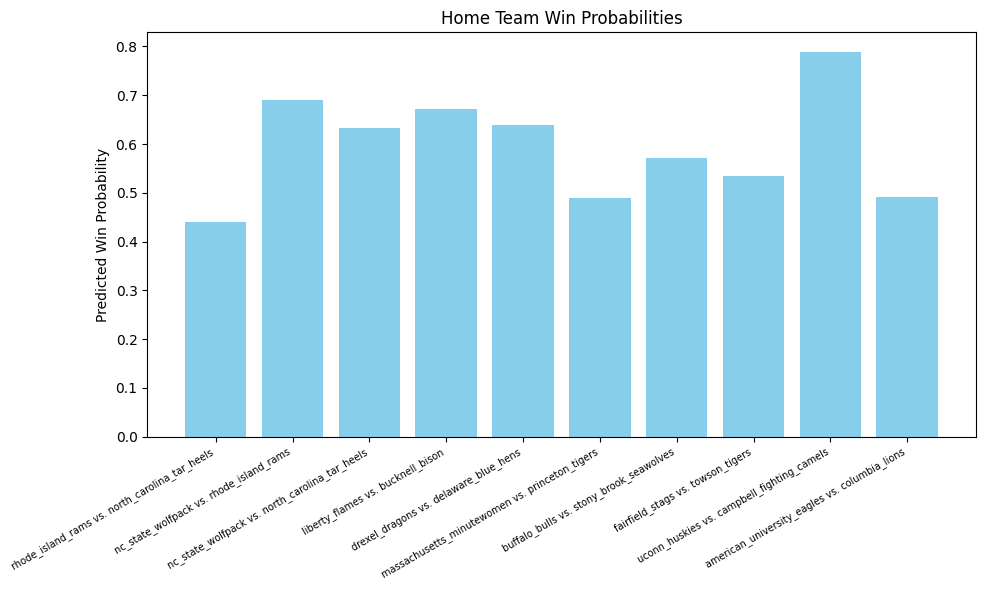

In [ ]:
import matplotlib.pyplot as plt

# Example DataFrame
regional_games = pd.DataFrame({
     "predicted_prob_model": [0.440315, 0.690673, 0.633859, 0.671026, 0.639353,
                              0.488742, 0.571987, 0.534884, 0.789538, 0.492365],
     "team_home": ["rhode_island_rams vs. north_carolina_tar_heels", "nc_state_wolfpack vs. rhode_island_rams", "nc_state_wolfpack vs. north_carolina_tar_heels",
                   "liberty_flames vs. bucknell_bison", "drexel_dragons vs. delaware_blue_hens", "massachusetts_minutewomen vs. princeton_tigers",
                   "buffalo_bulls vs. stony_brook_seawolves", "fairfield_stags vs. towson_tigers", "uconn_huskies vs. campbell_fighting_camels", "american_university_eagles vs. columbia_lions"]
 })

# 1. (Optional) Sort the DataFrame by predicted probability if you want a sorted bar chart.
#regional_games = regional_games.sort_values("predicted_prob_model", ascending=False)

# 2. Extract the columns for plotting
teams = regional_games["team_home"]
probs = regional_games["predicted_prob_model"]

# 3. Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(teams, probs, color='skyblue')
plt.xticks(rotation=30, ha='right', fontsize=7)  # Rotate x-axis labels for readability
plt.ylabel("Predicted Win Probability")
plt.title("Home Team Win Probabilities")

# 4. Adjust layout and display
plt.tight_layout()
plt.show()


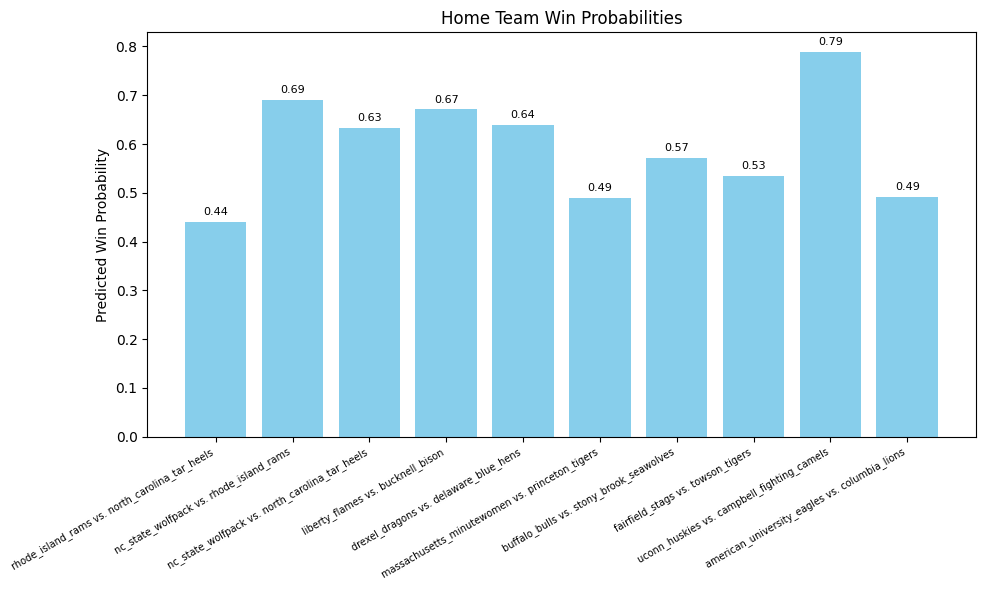

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Example DataFrame
regional_games = pd.DataFrame({
     "predicted_prob_model": [0.440315, 0.690673, 0.633859, 0.671026, 0.639353,
                              0.488742, 0.571987, 0.534884, 0.789538, 0.492365],
     "team_home": ["rhode_island_rams vs. north_carolina_tar_heels", "nc_state_wolfpack vs. rhode_island_rams", "nc_state_wolfpack vs. north_carolina_tar_heels",
                   "liberty_flames vs. bucknell_bison", "drexel_dragons vs. delaware_blue_hens", "massachusetts_minutewomen vs. princeton_tigers",
                   "buffalo_bulls vs. stony_brook_seawolves", "fairfield_stags vs. towson_tigers", "uconn_huskies vs. campbell_fighting_camels", "american_university_eagles vs. columbia_lions"]
 })

# 1. (Optional) Sort the DataFrame by predicted probability
# regional_games = regional_games.sort_values("predicted_prob_model", ascending=False)

# 2. Extract the columns for plotting
teams = regional_games["team_home"]
probs = regional_games["predicted_prob_model"]

# 3. Create the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(teams, probs, color='skyblue')

# 4. Add probability labels on top of each bar
for bar in bars:
    height = bar.get_height()
    # Place the text slightly above the top of the bar (height + 0.01)
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.01,
        f"{height:.2f}",
        ha='center',
        va='bottom',
        fontsize=8
    )

plt.xticks(rotation=30, ha='right', fontsize=7)
plt.ylabel("Predicted Win Probability")
plt.title("Home Team Win Probabilities")

# 5. Adjust layout and display
plt.tight_layout()
plt.show()


In [ ]:
regional_games[["predicted_prob_model", "team_home", "team_away"]]

KeyError: "['team_away'] not in index"

In [ ]:
from sklearn.metrics import accuracy_score

X_test_ = xgb.DMatrix(X_test)
# Make predictions using the XGBoost model
y_pred_prob = model.predict(X_test_)  # XGBoost outputs raw predictions

# Convert probabilities to binary predictions (threshold = 0.5)
y_pred = (y_pred_prob >= 0.5).astype(int)

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")


Accuracy: 0.8032


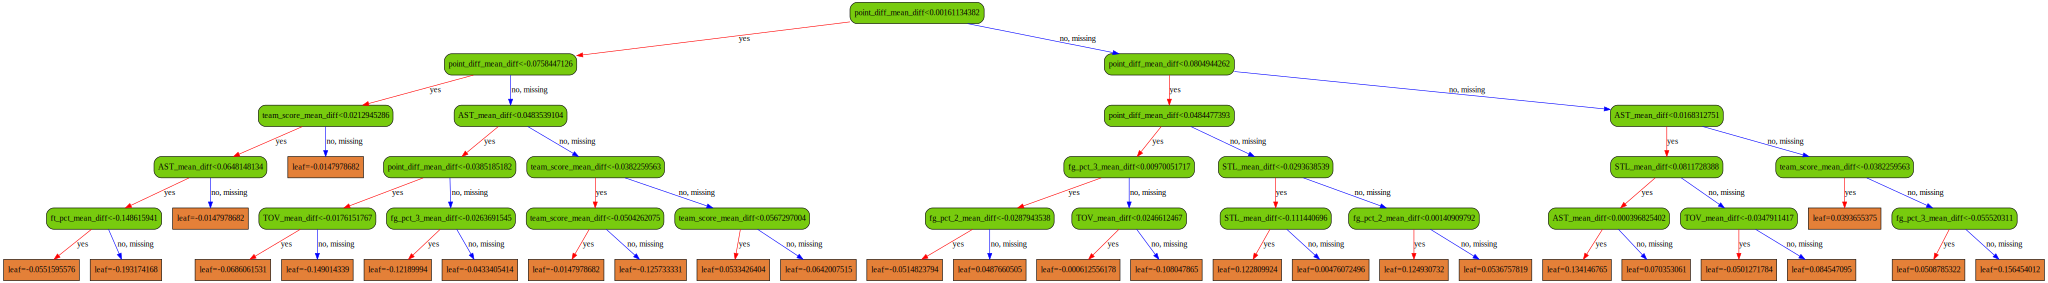

In [ ]:
bst = model
#for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
 #   print('%s: ' % importance_type, bst.get_score(importance_type=importance_type))


node_params = {'shape': 'box',
              'style': 'filled, rounded',
              'fillcolor': '#78cbe'}

leaf_params = {'shape': 'box',
              'style': 'filled',
              'fillcolor': '#e48038'}

xgb.to_graphviz(model, num_trees=0, size="10,10",
               condition_node_params=node_params,
               leaf_node_params=leaf_params

               )

In [ ]:
team_agg

,team,win_percentage,total_wins,team_score_mean,opponent_team_score_mean,fg_pct_2_mean,fg_pct_3_mean,ft_pct_mean,AST_mean,BLK_mean,STL_mean,TOV_mean,TOV_team_mean,DREB_mean,OREB_mean,F_personal_mean,F_tech_mean,OT_length_min_tot_mean,largest_lead_mean,rest_days_mean,attendance_mean,tz_dif_H_E_mean,prev_game_dist_mean,travel_dist_mean,point_diff_mean,region,elo_rating,combined_rank_score
262,south_carolina_gamecocks,0.935484,29,0.441966,0.258667,0.476529,0.315578,0.676142,0.366487,0.712499,0.232975,0.308419,0.202061,0.563275,0.521169,0.312175,0.000000,0.010753,0.683199,0.394258,0.831776,0.467742,0.496808,0.408745,0.183298,North,1707.349408,0.752300
85,florida_gulf_coast_eagles,0.923077,24,0.485262,0.322070,0.574094,0.333584,0.643437,0.439103,0.474550,0.353276,0.224203,0.278662,0.420118,0.268029,0.357320,0.000000,0.000000,0.659617,0.410602,0.560688,0.500000,0.508339,0.371911,0.163192,North,1671.877632,0.740185
182,nc_state_wolfpack,0.906250,29,0.489486,0.308703,0.508094,0.367841,0.767493,0.368056,0.418930,0.269676,0.250762,0.068680,0.542468,0.375000,0.296371,0.018750,0.020833,0.652206,0.387569,0.747550,0.479167,0.403998,0.304096,0.180783,NaN,1710.561783,0.738219
278,stanford_cardinal,0.903226,28,0.465179,0.307205,0.500605,0.358444,0.673766,0.392473,0.631627,0.318996,0.268293,0.192523,0.491315,0.417339,0.386056,0.000000,0.000000,0.640675,0.378475,0.673757,0.483871,0.415306,0.420103,0.157974,West,1699.737450,0.734902
307,ucf_knights,0.888889,24,0.342679,0.219453,0.438113,0.307366,0.701903,0.349794,0.462390,0.417010,0.334237,0.268341,0.376068,0.429398,0.311828,0.007407,0.000000,0.580225,0.417590,0.611184,0.456790,0.575950,0.440928,0.123226,North,1668.665847,0.722555
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,detroit_mercy_titans,0.037037,1,0.292835,0.418830,0.407079,0.262656,0.655214,0.276749,0.373759,0.334705,0.433604,0.181466,0.385565,0.358796,0.446834,0.014815,0.012346,0.208712,0.398821,0.416309,0.500000,0.417984,0.315842,-0.125995,NaN,1319.290953,0.238400
31,butler_bulldogs,0.035714,1,0.295060,0.503672,0.474366,0.261624,0.689546,0.288690,0.310307,0.182540,0.435540,0.296922,0.386447,0.290179,0.335253,0.000000,0.035714,0.203671,0.403987,0.516992,0.500000,0.413786,0.255909,-0.208611,NaN,1318.480270,0.237604
311,ul_monroe_warhawks,0.000000,0,0.304163,0.461342,0.386973,0.231866,0.669633,0.241162,0.394936,0.306397,0.385809,0.295437,0.334499,0.403409,0.486804,0.027273,0.015152,0.227693,0.426300,0.493391,0.492424,0.459042,0.315611,-0.157179,NaN,1331.890491,0.221982
64,delaware_state_hornets,0.000000,0,0.209856,0.490229,0.386449,0.233655,0.659957,0.188131,0.256635,0.161616,0.493348,0.485209,0.399767,0.291193,0.275660,0.045455,0.015152,0.159871,0.425030,0.449940,0.500000,0.511729,0.355291,-0.280374,NaN,1329.466526,0.221578


In [ ]:
a = team_agg[team_agg['team'] == 'rhode_island_rams']
a

,team,win_percentage,total_wins,team_score_mean,opponent_team_score_mean,fg_pct_2_mean,fg_pct_3_mean,ft_pct_mean,AST_mean,BLK_mean,STL_mean,TOV_mean,TOV_team_mean,DREB_mean,OREB_mean,F_personal_mean,F_tech_mean,OT_length_min_tot_mean,largest_lead_mean,rest_days_mean,attendance_mean,tz_dif_H_E_mean,prev_game_dist_mean,travel_dist_mean,point_diff_mean,region,elo_rating,combined_rank_score
236,rhode_island_rams,0.785714,22,0.371829,0.266021,0.46583,0.345943,0.66323,0.357143,0.4205,0.291005,0.301394,0.229968,0.475275,0.367188,0.274194,0.021429,0.0,0.580841,0.400785,0.530181,0.5,0.518132,0.58473,0.105808,NaN,1621.692433,0.663139


In [ ]:
b = team_agg[team_agg['team'] == 'north_carolina_tar_heels']
b

,team,win_percentage,total_wins,team_score_mean,opponent_team_score_mean,fg_pct_2_mean,fg_pct_3_mean,ft_pct_mean,AST_mean,BLK_mean,STL_mean,TOV_mean,TOV_team_mean,DREB_mean,OREB_mean,F_personal_mean,F_tech_mean,OT_length_min_tot_mean,largest_lead_mean,rest_days_mean,attendance_mean,tz_dif_H_E_mean,prev_game_dist_mean,travel_dist_mean,point_diff_mean,region,elo_rating,combined_rank_score
196,north_carolina_tar_heels,0.777778,21,0.470059,0.297681,0.445793,0.321592,0.706679,0.365226,0.514962,0.363512,0.287263,0.152839,0.506173,0.462963,0.383513,0.02963,0.012346,0.644583,0.427537,0.695894,0.5,0.543477,0.577294,0.172378,NaN,1619.097987,0.658739


# Ranking

In [ ]:
team_agg.drop(columns=['opponent_team_score_mean', 'TOV_mean', 'TOV_team_mean', 'OT_length_min_tot_mean', 'rest_days_mean', 'tz_dif_H_E_mean', 'prev_game_dist_mean', 'travel_dist_mean', 'point_diff_mean', 'region'], inplace=True)

In [ ]:
ranking = pd.merge(team_regions, team_agg, on=['team'], how='left')
ranking = ranking[~(ranking['win_percentage'].isna())]

features_to_scale = ['total_wins', 'elo_rating']
scaler = MinMaxScaler(feature_range=(0, 1))
ranking[features_to_scale] = scaler.fit_transform(ranking[features_to_scale])
ranking

,team,region,win_percentage,total_wins,team_score_mean,fg_pct_2_mean,fg_pct_3_mean,ft_pct_mean,AST_mean,BLK_mean,STL_mean,DREB_mean,OREB_mean,F_personal_mean,F_tech_mean,largest_lead_mean,attendance_mean,elo_rating,combined_rank_score
0,alabama_crimson_tide,North,0.566667,0.294118,0.434891,0.467527,0.335122,0.708576,0.283333,0.434958,0.329630,0.417949,0.376042,0.416129,0.020000,0.511084,0.705633,0.250511,0.539751
1,alabama_state_lady_hornets,North,0.481481,0.058824,0.365178,0.406138,0.289688,0.678347,0.344650,0.515411,0.255144,0.420703,0.442130,0.559140,0.051852,0.391858,0.531854,0.000000,0.487752
2,arkansas_razorbacks,North,0.580645,0.352941,0.464878,0.467804,0.323014,0.676956,0.326165,0.571328,0.272401,0.456576,0.346774,0.401665,0.012903,0.507477,0.718469,0.288512,0.548167
3,belmont_bruins,North,0.758621,0.588235,0.425073,0.512895,0.329089,0.692107,0.402299,0.496145,0.330779,0.385500,0.344828,0.344828,0.000000,0.584885,0.579638,0.587705,0.648388
4,charleston_cougars,North,0.535714,0.176471,0.453271,0.446814,0.286593,0.760101,0.345238,0.497138,0.386243,0.379121,0.440848,0.369816,0.014286,0.473581,0.424833,0.134492,0.519918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,ut_arlington_mavericks,West,0.740741,0.470588,0.429560,0.476585,0.272106,0.690607,0.404321,0.477238,0.293553,0.463438,0.335648,0.400239,0.014815,0.533610,0.540811,0.569349,0.638759
135,utah_utes,West,0.645161,0.470588,0.486283,0.494864,0.346593,0.784853,0.396057,0.385041,0.253286,0.425145,0.417339,0.405827,0.064516,0.537464,0.684906,0.453177,0.586608
136,utah_valley_wolverines,West,0.482759,0.117647,0.359974,0.482994,0.301357,0.785739,0.379310,0.365544,0.197957,0.485411,0.325431,0.369299,0.020690,0.468169,0.526116,0.101047,0.492185
137,washington_state_cougars,West,0.655172,0.411765,0.343539,0.425022,0.332651,0.695577,0.342912,0.519461,0.292465,0.381963,0.349138,0.372636,0.034483,0.480665,0.597482,0.435254,0.590940


In [ ]:
ranking.columns

Index(['team', 'region', 'win_percentage', 'total_wins', 'team_score_mean',
       'fg_pct_2_mean', 'fg_pct_3_mean', 'ft_pct_mean', 'AST_mean', 'BLK_mean',
       'STL_mean', 'DREB_mean', 'OREB_mean', 'F_personal_mean', 'F_tech_mean',
       'largest_lead_mean', 'attendance_mean', 'elo_rating',
       'combined_rank_score'],
      dtype='object')

In [ ]:
ranking_north = ranking[ranking['region'] == 'North']
ranking_south = ranking[ranking['region'] == 'South']
ranking_west = ranking[ranking['region'] == 'West']

In [ ]:
ranking_north['team'].nunique()

47

In [ ]:
ranking_south['team'].nunique()

41

In [ ]:
ranking_west['team'].nunique()

47

# Clustering

# North

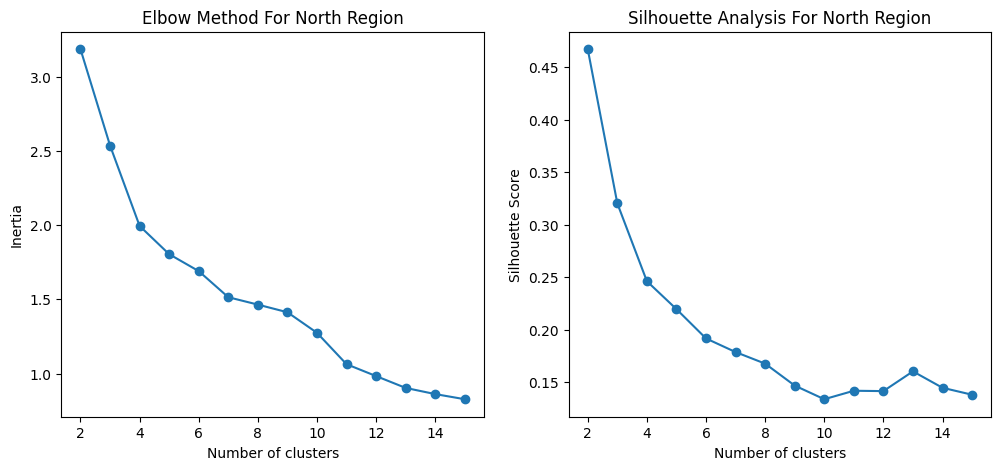

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

df = ranking_north

features_scaled = df[['win_percentage', 'total_wins', 'team_score_mean',
       'fg_pct_2_mean', 'fg_pct_3_mean', 'ft_pct_mean', 'AST_mean', 'BLK_mean',
       'STL_mean', 'DREB_mean', 'OREB_mean',
       'largest_lead_mean', 'elo_rating',
       'combined_rank_score']]

features = df.drop(columns=['team', 'region'])


# Assuming 'features_scaled' contains your scaled performance features
inertia = []
silhouette = []
K_range = range(2, 16)  # trying cluster numbers from 2 to 10

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled)
    inertia.append(kmeans.inertia_)
    score = silhouette_score(features_scaled, kmeans.labels_)
    silhouette.append(score)

# Plot the Elbow Method result
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(K_range, inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For North Region')

# Plot the Silhouette Analysis result
plt.subplot(1, 2, 2)
plt.plot(K_range, silhouette, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis For North Region')
plt.show()


In [ ]:
from sklearn.cluster import KMeans

# 3. Apply KMeans clustering
# Set the number of clusters (adjust as needed)
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(features_scaled)
centroids = kmeans.cluster_centers_

# 4. Rank clusters by their centroids
# Here we sum the centroid values to get a single score per cluster.
# This approach assumes that for every feature, a higher value is better.
cluster_scores = {}
for i in range(n_clusters):
    cluster_scores[i] = np.sum(centroids[i])

# Order clusters from best to worst (highest summed value is best)
sorted_clusters = sorted(cluster_scores.items(), key=lambda x: x[1], reverse=True)
print("Cluster ranking based on centroids (best to worst):")
for rank, (cluster_label, score) in enumerate(sorted_clusters, 1):
    print(f"Rank {rank}: Cluster {cluster_label} with score {score:.2f}")

# Create a mapping from cluster label to overall cluster rank
cluster_order = {cluster_label: rank for rank, (cluster_label, _) in enumerate(sorted_clusters, 1)}
df['cluster_order'] = df['cluster'].map(cluster_order)

# 5. Compute distance of each team (in scaled space) to its cluster centroid
# Create a DataFrame of scaled features to ease distance computation.
scaled_df = pd.DataFrame(features_scaled)
df['distance'] = [
    np.linalg.norm(scaled_df.iloc[i].values - centroids[cluster])
    for i, cluster in enumerate(df['cluster'])
]

# Within each cluster, rank teams based on distance (lower distance = closer to the centroid)
df['within_cluster_rank'] = df.groupby('cluster')['distance'].rank(method='first', ascending=True)

# 6. Sort teams: first by the cluster rank (best clusters first) then by within-cluster ranking
df_sorted = df.sort_values(by=['cluster_order', 'within_cluster_rank'])

# Display the final rankings with selected columns
print("\nFinal Team Rankings:")
print(df_sorted[['team', 'cluster', 'cluster_order', 'distance', 'within_cluster_rank']])

Cluster ranking based on centroids (best to worst):
Rank 1: Cluster 1 with score 7.71
Rank 2: Cluster 2 with score 6.98
Rank 3: Cluster 3 with score 5.99
Rank 4: Cluster 0 with score 5.42

Final Team Rankings:
                               team  cluster  cluster_order  distance  \
46                      ucf_knights        1              1  0.179738   
39       stephen_f_austin_ladyjacks        1              1  0.197239   
26                       lsu_tigers        1              1  0.211708   
9         florida_gulf_coast_eagles        1              1  0.228877   
37              south_florida_bulls        1              1  0.241220   
35         south_carolina_gamecocks        1              1  0.445773   
31                  ole_miss_rebels        2              2  0.117894   
8                    florida_gators        2              2  0.154463   
5                   charlotte_49ers        2              2  0.158938   
44                tulane_green_wave        2              2 

<ipython-input-174-ba0a9719ca52>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster'] = kmeans.fit_predict(features_scaled)
<ipython-input-174-ba0a9719ca52>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster_order'] = df['cluster'].map(cluster_order)
<ipython-input-174-ba0a9719ca52>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

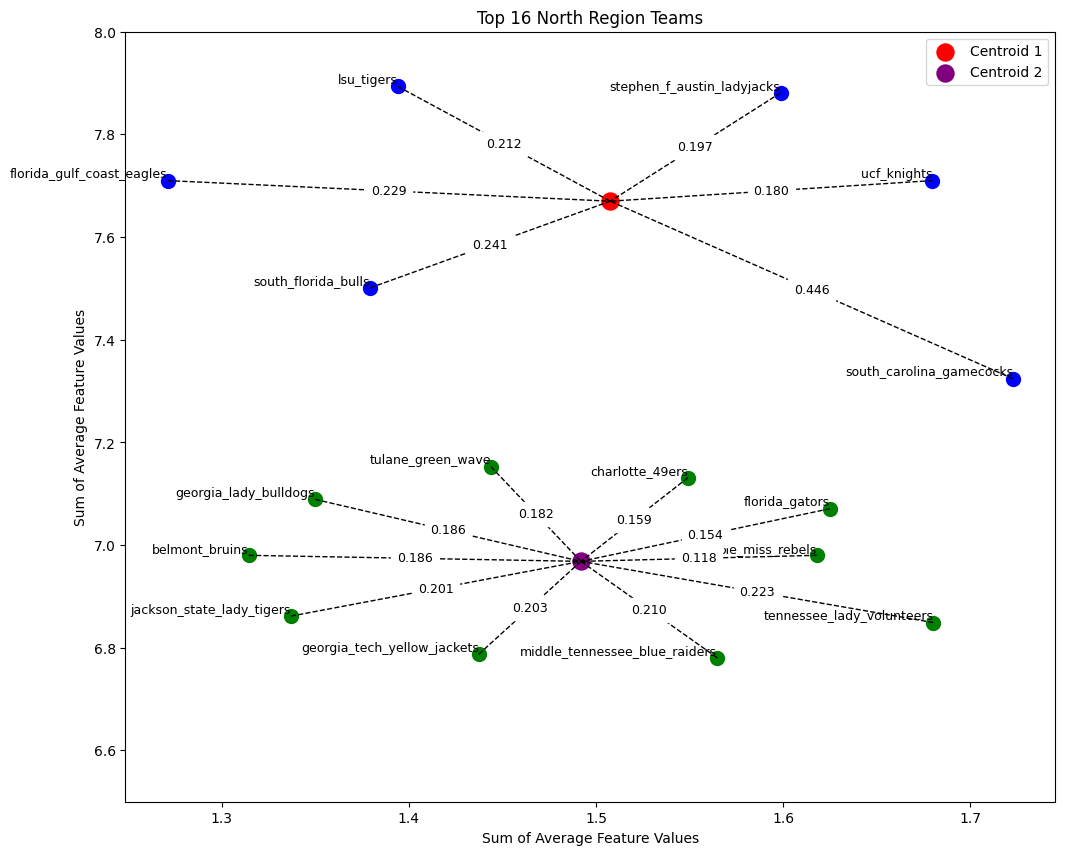

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define the centroids with new y-values (one above the other)
centroid1 = np.array([1.5, 7.71])  # Centroid 1 for cluster 1 with y = 7.71
centroid2 = np.array([1.5, 6.98])  # Centroid 2 for cluster 2 with y = 6.98

# Team data from the image for clusters 1 and 2 with their distances
cluster1_teams = {
    "ucf_knights": 0.179738,
    "stephen_f_austin_ladyjacks": 0.197239,
    "lsu_tigers": 0.211708,
    "florida_gulf_coast_eagles": 0.228877,
    "south_florida_bulls": 0.241220,
    "south_carolina_gamecocks": 0.445773
}

cluster2_teams = {
    "ole_miss_rebels": 0.117894,
    "florida_gators": 0.154463,
    "charlotte_49ers": 0.158938,
    "tulane_green_wave": 0.181696,
    "georgia_lady_bulldogs": 0.185529,
    "belmont_bruins": 0.185529,
    "jackson_state_lady_tigers": 0.201486,
    "georgia_tech_yellow_jackets": 0.202629,
    "middle_tennessee_blue_raiders": 0.209884,
    "tennessee_lady_volunteers": 0.222797
}

# Function to generate approximate 2D coordinates around a centroid using distance and random angle
def generate_points_around_centroid(centroid, distances, num_points):
    angles = np.linspace(0, 2 * np.pi, num_points, endpoint=False)
    points = []
    for i, (team, dist) in enumerate(distances.items()):
        x = centroid[0] + dist * np.cos(angles[i % len(angles)])
        y = centroid[1] + dist * np.sin(angles[i % len(angles)])
        points.append((team, np.array([x, y]), dist))
    return points

# Generate points for cluster 1
cluster1_points = generate_points_around_centroid(centroid1, cluster1_teams, len(cluster1_teams))
# Generate points for cluster 2
cluster2_points = generate_points_around_centroid(centroid2, cluster2_teams, len(cluster2_teams))

# Extract coordinates and team names
cluster1_coords = np.array([pt[1] for pt in cluster1_points])
cluster1_names = [pt[0] for pt in cluster1_points]
cluster1_distances = [pt[2] for pt in cluster1_points]

cluster2_coords = np.array([pt[1] for pt in cluster2_points])
cluster2_names = [pt[0] for pt in cluster2_points]
cluster2_distances = [pt[2] for pt in cluster2_points]

# Compute actual centroids (should be close to predefined centroids)
centroid1_actual = np.mean(cluster1_coords, axis=0)
centroid2_actual = np.mean(cluster2_coords, axis=0)

# Plotting
plt.figure(figsize=(12, 10))

# Plot the data points for cluster 1 with team names as labels
for (x, y), name, dist in zip(cluster1_coords, cluster1_names, cluster1_distances):
    plt.scatter(x, y, color='blue', s=100)
    plt.text(x, y, name, fontsize=9, ha='right', va='bottom')
    plt.plot([x, centroid1_actual[0]], [y, centroid1_actual[1]], 'k--', lw=1)
    plt.text((x + centroid1_actual[0]) / 2, (y + centroid1_actual[1]) / 2, f"{dist:.3f}", fontsize=9, ha='center', va='center', backgroundcolor='white')

# Plot the data points for cluster 2 with team names as labels
for (x, y), name, dist in zip(cluster2_coords, cluster2_names, cluster2_distances):
    plt.scatter(x, y, color='green', s=100)
    plt.text(x, y, name, fontsize=9, ha='right', va='bottom')
    plt.plot([x, centroid2_actual[0]], [y, centroid2_actual[1]], 'k--', lw=1)
    plt.text((x + centroid2_actual[0]) / 2, (y + centroid2_actual[1]) / 2, f"{dist:.3f}", fontsize=9, ha='center', va='center', backgroundcolor='white')

# Plot the centroids
plt.scatter([centroid1_actual[0]], [centroid1_actual[1]], color='red', label='Centroid 1', s=150)
plt.scatter([centroid2_actual[0]], [centroid2_actual[1]], color='purple', label='Centroid 2', s=150)

plt.xlabel('Sum of Average Feature Values')
plt.ylabel('Sum of Average Feature Values')
plt.title('Top 16 North Region Teams')
plt.legend()
plt.grid(False)
plt.ylim(6.5, 8)  # Adjust y-axis limits to focus on the new centroid range
plt.show()


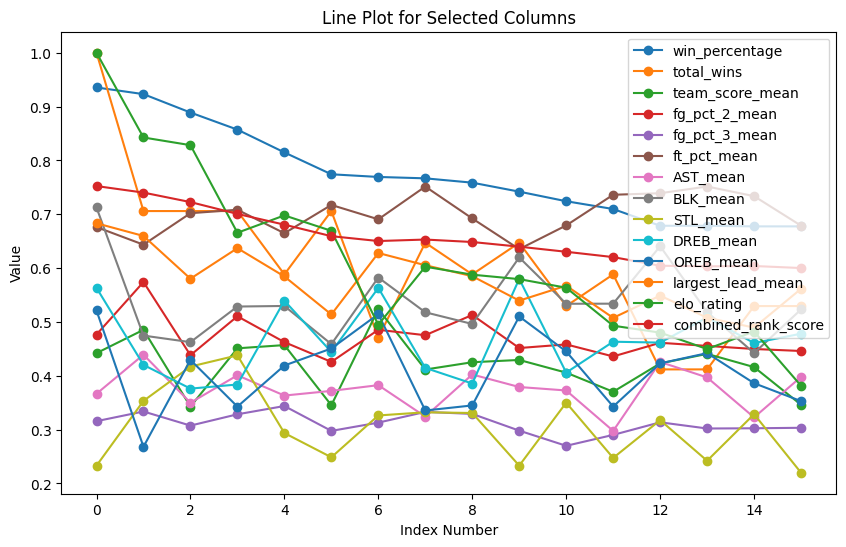

In [ ]:
teams_north = [
    "ucf_knights",
    "stephen_f_austin_ladyjacks",
    "lsu_tigers",
    "florida_gulf_coast_eagles",
    "south_florida_bulls",
    "south_carolina_gamecocks",
    "ole_miss_rebels",
    "florida_gators",
    "charlotte_49ers",
    "tulane_green_wave",
    "georgia_lady_bulldogs",
    "belmont_bruins",
    "jackson_state_lady_tigers",
    "georgia_tech_yellow_jackets",
    "middle_tennessee_blue_raiders",
    "tennessee_lady_volunteers"
]



a = ranking[ranking['team'].isin(teams_north)]
a = a.sort_values(['win_percentage'], ascending=False).reset_index()

import matplotlib.pyplot as plt

# Define your list of columns
cols = ['win_percentage', 'total_wins', 'team_score_mean',
       'fg_pct_2_mean', 'fg_pct_3_mean', 'ft_pct_mean', 'AST_mean', 'BLK_mean',
       'STL_mean', 'DREB_mean', 'OREB_mean',
       'largest_lead_mean', 'elo_rating',
       'combined_rank_score']

plt.figure(figsize=(10, 6))

# Loop over the columns and plot each as a separate line
for col in cols:
    plt.plot(a.index, a[col], marker='o', label=col)

plt.xlabel('Index Number')
plt.ylabel('Value')
plt.title('Line Plot for Selected Columns')
plt.legend(loc='best')
plt.show()


## South

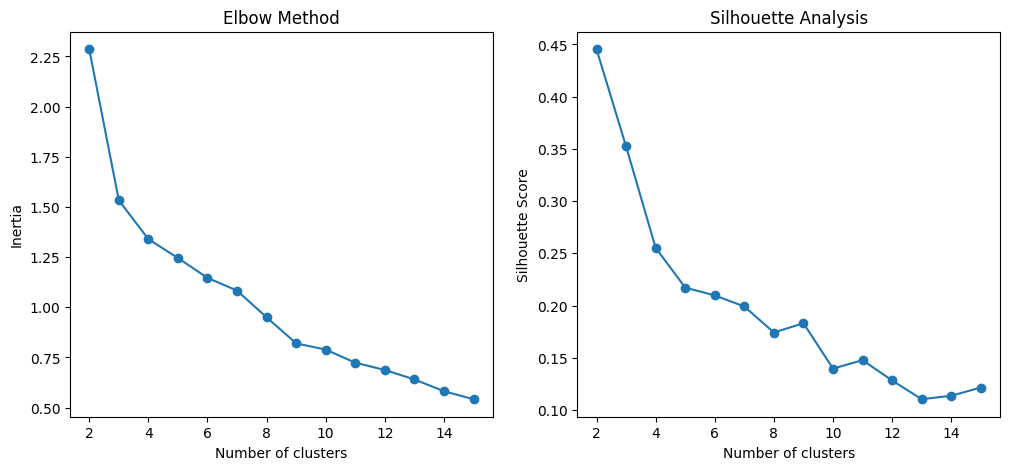

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

df = ranking_south

features_scaled = df[['win_percentage', 'total_wins', 'team_score_mean',
       'fg_pct_2_mean', 'fg_pct_3_mean', 'ft_pct_mean', 'AST_mean', 'BLK_mean',
       'STL_mean', 'DREB_mean', 'OREB_mean',
       'largest_lead_mean', 'elo_rating',
       'combined_rank_score']]

features = df.drop(columns=['team', 'region'])


# Assuming 'features_scaled' contains your scaled performance features
inertia = []
silhouette = []
K_range = range(2, 16)  # trying cluster numbers from 2 to 10

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled)
    inertia.append(kmeans.inertia_)
    score = silhouette_score(features_scaled, kmeans.labels_)
    silhouette.append(score)

# Plot the Elbow Method result
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(K_range, inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')

# Plot the Silhouette Analysis result
plt.subplot(1, 2, 2)
plt.plot(K_range, silhouette, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')
plt.show()


In [ ]:
from sklearn.cluster import KMeans

# 3. Apply KMeans clustering
# Set the number of clusters (adjust as needed)
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(features_scaled)
centroids = kmeans.cluster_centers_

# 4. Rank clusters by their centroids
# Here we sum the centroid values to get a single score per cluster.
# This approach assumes that for every feature, a higher value is better.
cluster_scores = {}
for i in range(n_clusters):
    cluster_scores[i] = np.sum(centroids[i])

# Order clusters from best to worst (highest summed value is best)
sorted_clusters = sorted(cluster_scores.items(), key=lambda x: x[1], reverse=True)
print("Cluster ranking based on centroids (best to worst):")
for rank, (cluster_label, score) in enumerate(sorted_clusters, 1):
    print(f"Rank {rank}: Cluster {cluster_label} with score {score:.2f}")

# Create a mapping from cluster label to overall cluster rank
cluster_order = {cluster_label: rank for rank, (cluster_label, _) in enumerate(sorted_clusters, 1)}
df['cluster_order'] = df['cluster'].map(cluster_order)

# 5. Compute distance of each team (in scaled space) to its cluster centroid
# Create a DataFrame of scaled features to ease distance computation.
scaled_df = pd.DataFrame(features_scaled)
df['distance'] = [
    np.linalg.norm(scaled_df.iloc[i].values - centroids[cluster])
    for i, cluster in enumerate(df['cluster'])
]

# Within each cluster, rank teams based on distance (lower distance = closer to the centroid)
df['within_cluster_rank'] = df.groupby('cluster')['distance'].rank(method='first', ascending=True)

# 6. Sort teams: first by the cluster rank (best clusters first) then by within-cluster ranking
df_sorted = df.sort_values(by=['cluster_order', 'within_cluster_rank'])

# Display the final rankings with selected columns
print("\nFinal Team Rankings:")
print(df_sorted[['team', 'cluster', 'cluster_order', 'distance', 'within_cluster_rank']])

Cluster ranking based on centroids (best to worst):
Rank 1: Cluster 0 with score 7.41
Rank 2: Cluster 2 with score 6.53
Rank 3: Cluster 1 with score 5.62

Final Team Rankings:
                             team  cluster  cluster_order  distance  \
63        iu_indianapolis_jaguars        0              1  0.129845   
82            ohio_state_buckeyes        0              1  0.136623   
73            michigan_wolverines        0              1  0.147430   
60               indiana_hoosiers        0              1  0.161788   
87           virginia_tech_hokies        0              1  0.177746   
54                  dayton_flyers        0              1  0.182287   
85                 toledo_rockets        0              1  0.198809   
80      notre_dame_fighting_irish        0              1  0.210807   
68           louisville_cardinals        0              1  0.215203   
62            iowa_state_cyclones        0              1  0.217576   
61                  iowa_hawkeyes        0 

<ipython-input-181-5a3ebfa42191>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster'] = kmeans.fit_predict(features_scaled)
<ipython-input-181-5a3ebfa42191>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster_order'] = df['cluster'].map(cluster_order)
<ipython-input-181-5a3ebfa42191>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

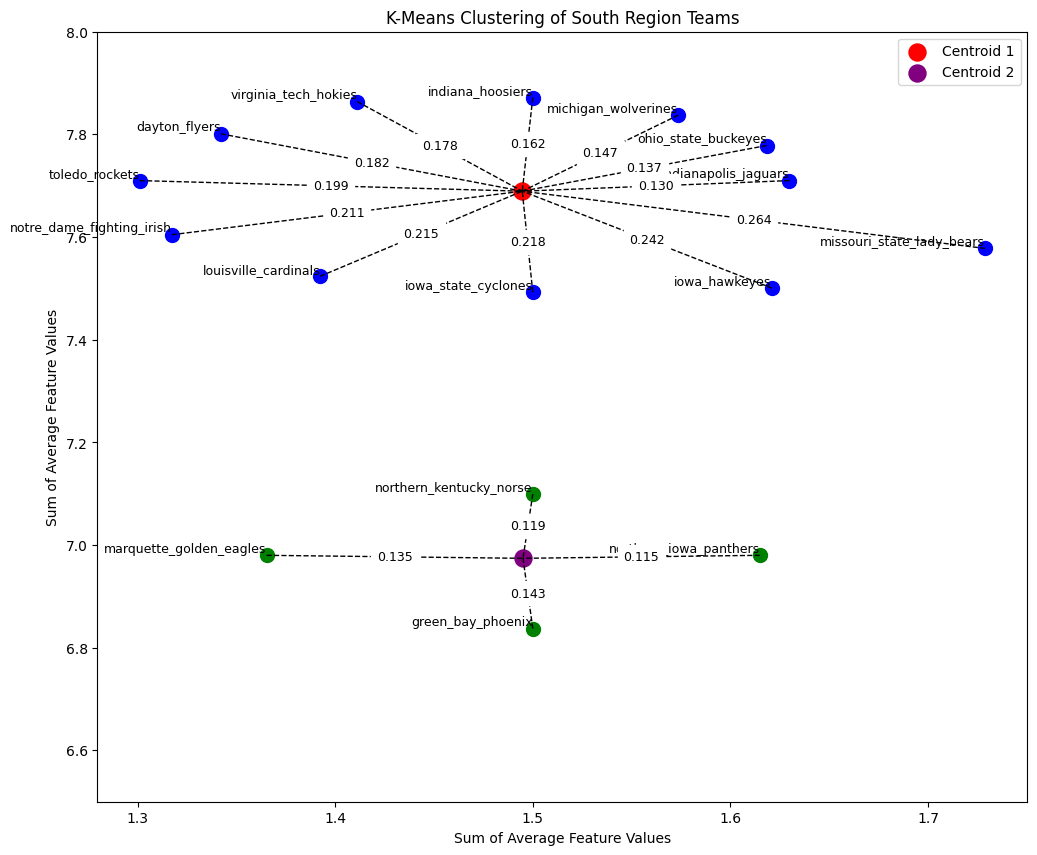

In [ ]:
# Define centroids based on cluster order
centroid1 = np.array([1.5, 7.71])  # Centroid 1 (for cluster_order = 1)
centroid2 = np.array([1.5, 6.98])  # Centroid 2 (for cluster_order != 1)

# Teams and their distances from the provided image data
south_teams = [
    ("iu_indianapolis_jaguars", 0, 1, 0.129845),
    ("ohio_state_buckeyes", 0, 1, 0.136623),
    ("michigan_wolverines", 0, 1, 0.147430),
    ("indiana_hoosiers", 0, 1, 0.161788),
    ("virginia_tech_hokies", 0, 1, 0.177746),
    ("dayton_flyers", 0, 1, 0.182287),
    ("toledo_rockets", 0, 1, 0.198889),
    ("notre_dame_fighting_irish", 0, 1, 0.210807),
    ("louisville_cardinals", 0, 1, 0.215203),
    ("iowa_state_cyclones", 0, 1, 0.217576),
    ("iowa_hawkeyes", 0, 1, 0.241747),
    ("missouri_state_lady_bears", 0, 1, 0.264313),
    ("northern_iowa_panthers", 2, 2, 0.114813),
    ("northern_kentucky_norse", 2, 2, 0.119305),
    ("marquette_golden_eagles", 2, 2, 0.134672),
    ("green_bay_phoenix", 2, 2, 0.142637)
]

# Separate teams based on cluster order
cluster1_teams = {team: dist for team, cluster, order, dist in teams_data if order == 1}
cluster2_teams = {team: dist for team, cluster, order, dist in teams_data if order != 1}

# Generate points for cluster 1
cluster1_points = generate_points_around_centroid(centroid1, cluster1_teams, len(cluster1_teams))
# Generate points for cluster 2
cluster2_points = generate_points_around_centroid(centroid2, cluster2_teams, len(cluster2_teams))

# Extract coordinates and team names
cluster1_coords = np.array([pt[1] for pt in cluster1_points])
cluster1_names = [pt[0] for pt in cluster1_points]
cluster1_distances = [pt[2] for pt in cluster1_points]

cluster2_coords = np.array([pt[1] for pt in cluster2_points])
cluster2_names = [pt[0] for pt in cluster2_points]
cluster2_distances = [pt[2] for pt in cluster2_points]

# Compute actual centroids (should be close to predefined centroids)
centroid1_actual = np.mean(cluster1_coords, axis=0)
centroid2_actual = np.mean(cluster2_coords, axis=0)

# Plotting
plt.figure(figsize=(12, 10))

# Plot the data points for cluster 1 with team names as labels
for (x, y), name, dist in zip(cluster1_coords, cluster1_names, cluster1_distances):
    plt.scatter(x, y, color='blue', s=100)
    plt.text(x, y, name, fontsize=9, ha='right', va='bottom')
    plt.plot([x, centroid1_actual[0]], [y, centroid1_actual[1]], 'k--', lw=1)
    plt.text((x + centroid1_actual[0]) / 2, (y + centroid1_actual[1]) / 2, f"{dist:.3f}", fontsize=9, ha='center', va='center', backgroundcolor='white')

# Plot the data points for cluster 2 with team names as labels
for (x, y), name, dist in zip(cluster2_coords, cluster2_names, cluster2_distances):
    plt.scatter(x, y, color='green', s=100)
    plt.text(x, y, name, fontsize=9, ha='right', va='bottom')
    plt.plot([x, centroid2_actual[0]], [y, centroid2_actual[1]], 'k--', lw=1)
    plt.text((x + centroid2_actual[0]) / 2, (y + centroid2_actual[1]) / 2, f"{dist:.3f}", fontsize=9, ha='center', va='center', backgroundcolor='white')

# Plot the centroids
plt.scatter([centroid1_actual[0]], [centroid1_actual[1]], color='red', label='Centroid 1', s=150)
plt.scatter([centroid2_actual[0]], [centroid2_actual[1]], color='purple', label='Centroid 2', s=150)

plt.xlabel('Sum of Average Feature Values')
plt.ylabel('Sum of Average Feature Values')
plt.title('K-Means Clustering of South Region Teams')
plt.legend()
plt.grid(False)
plt.ylim(6.5, 8)  # Adjust y-axis limits to focus on the centroid range
plt.show()


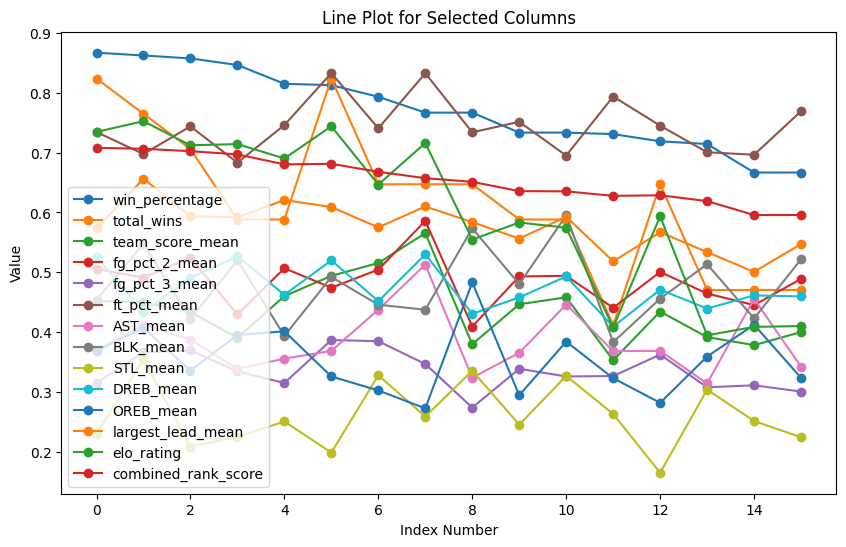

In [ ]:
teams_south = [
    "iu_indianapolis_jaguars",
    "ohio_state_buckeyes",
    "michigan_wolverines",
    "indiana_hoosiers",
    "virginia_tech_hokies",
    "dayton_flyers",
    "toledo_rockets",
    "notre_dame_fighting_irish",
    "louisville_cardinals",
    "iowa_state_cyclones",
    "iowa_hawkeyes",
    "missouri_state_lady_bears",
    "northern_iowa_panthers",
    "northern_kentucky_norse",
    "marquette_golden_eagles",
    "green_bay_phoenix"
]




a = ranking[ranking['team'].isin(teams_south)]
a = a.sort_values(['win_percentage'], ascending=False).reset_index()

import matplotlib.pyplot as plt

# Define your list of columns
cols = ['win_percentage', 'total_wins', 'team_score_mean',
       'fg_pct_2_mean', 'fg_pct_3_mean', 'ft_pct_mean', 'AST_mean', 'BLK_mean',
       'STL_mean', 'DREB_mean', 'OREB_mean',
       'largest_lead_mean', 'elo_rating',
       'combined_rank_score']

plt.figure(figsize=(10, 6))

# Loop over the columns and plot each as a separate line
for col in cols:
    plt.plot(a.index, a[col], marker='o', label=col)

plt.xlabel('Index Number')
plt.ylabel('Value')
plt.title('Line Plot for Selected Columns')
plt.legend(loc='best')
plt.show()


# West

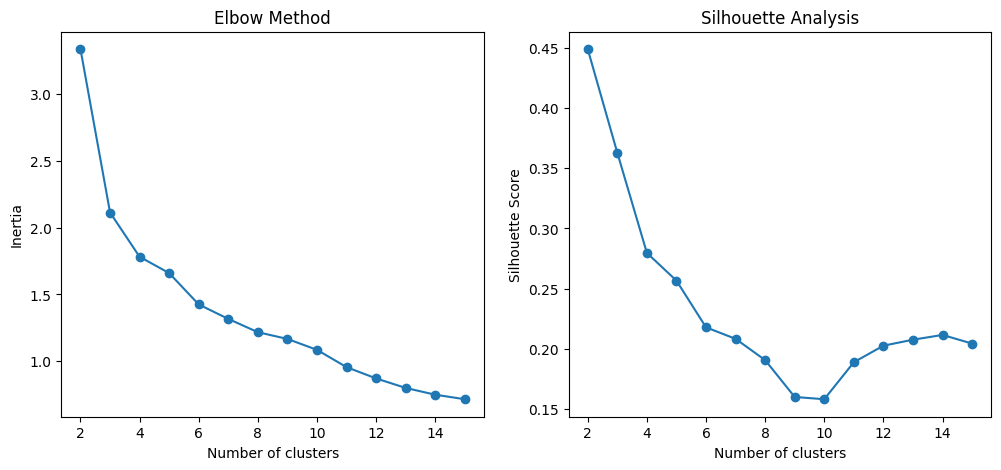

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

df = ranking_west

features_scaled = df[['win_percentage', 'total_wins', 'team_score_mean',
       'fg_pct_2_mean', 'fg_pct_3_mean', 'ft_pct_mean', 'AST_mean', 'BLK_mean',
       'STL_mean', 'DREB_mean', 'OREB_mean',
       'largest_lead_mean', 'elo_rating',
       'combined_rank_score']]

features = df.drop(columns=['team', 'region'])


# Assuming 'features_scaled' contains your scaled performance features
inertia = []
silhouette = []
K_range = range(2, 16)  # trying cluster numbers from 2 to 10

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled)
    inertia.append(kmeans.inertia_)
    score = silhouette_score(features_scaled, kmeans.labels_)
    silhouette.append(score)

# Plot the Elbow Method result
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(K_range, inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')

# Plot the Silhouette Analysis result
plt.subplot(1, 2, 2)
plt.plot(K_range, silhouette, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')
plt.show()


In [ ]:
from sklearn.cluster import KMeans

# 3. Apply KMeans clustering
# Set the number of clusters (adjust as needed)
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(features_scaled)
centroids = kmeans.cluster_centers_

# 4. Rank clusters by their centroids
# Here we sum the centroid values to get a single score per cluster.
# This approach assumes that for every feature, a higher value is better.
cluster_scores = {}
for i in range(n_clusters):
    cluster_scores[i] = np.sum(centroids[i])

# Order clusters from best to worst (highest summed value is best)
sorted_clusters = sorted(cluster_scores.items(), key=lambda x: x[1], reverse=True)
print("Cluster ranking based on centroids (best to worst):")
for rank, (cluster_label, score) in enumerate(sorted_clusters, 1):
    print(f"Rank {rank}: Cluster {cluster_label} with score {score:.2f}")

# Create a mapping from cluster label to overall cluster rank
cluster_order = {cluster_label: rank for rank, (cluster_label, _) in enumerate(sorted_clusters, 1)}
df['cluster_order'] = df['cluster'].map(cluster_order)

# 5. Compute distance of each team (in scaled space) to its cluster centroid
# Create a DataFrame of scaled features to ease distance computation.
scaled_df = pd.DataFrame(features_scaled)
df['distance'] = [
    np.linalg.norm(scaled_df.iloc[i].values - centroids[cluster])
    for i, cluster in enumerate(df['cluster'])
]

# Within each cluster, rank teams based on distance (lower distance = closer to the centroid)
df['within_cluster_rank'] = df.groupby('cluster')['distance'].rank(method='first', ascending=True)

# 6. Sort teams: first by the cluster rank (best clusters first) then by within-cluster ranking
df_sorted = df.sort_values(by=['cluster_order', 'within_cluster_rank'])

# Display the final rankings with selected columns
print("\nFinal Team Rankings:")
print(df_sorted[['team', 'cluster', 'cluster_order', 'distance', 'within_cluster_rank']])

Cluster ranking based on centroids (best to worst):
Rank 1: Cluster 0 with score 7.76
Rank 2: Cluster 2 with score 6.61
Rank 3: Cluster 1 with score 5.87
Rank 4: Cluster 3 with score 5.20

Final Team Rankings:
                                  team  cluster  cluster_order  distance  \
100                   gonzaga_bulldogs        0              1  0.116692   
94                        baylor_bears        0              1  0.121242   
108               nebraska_cornhuskers        0              1  0.182731   
126                    texas_longhorns        0              1  0.184896   
119               south_dakota_coyotes        0              1  0.192262   
95                         byu_cougars        0              1  0.211869   
133                   unlv_lady_rebels        0              1  0.224473   
113                   oklahoma_sooners        0              1  0.234102   
122                  stanford_cardinal        0              1  0.348851   
102              hawaii_rainbo

<ipython-input-193-ba0a9719ca52>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster'] = kmeans.fit_predict(features_scaled)
<ipython-input-193-ba0a9719ca52>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster_order'] = df['cluster'].map(cluster_order)
<ipython-input-193-ba0a9719ca52>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

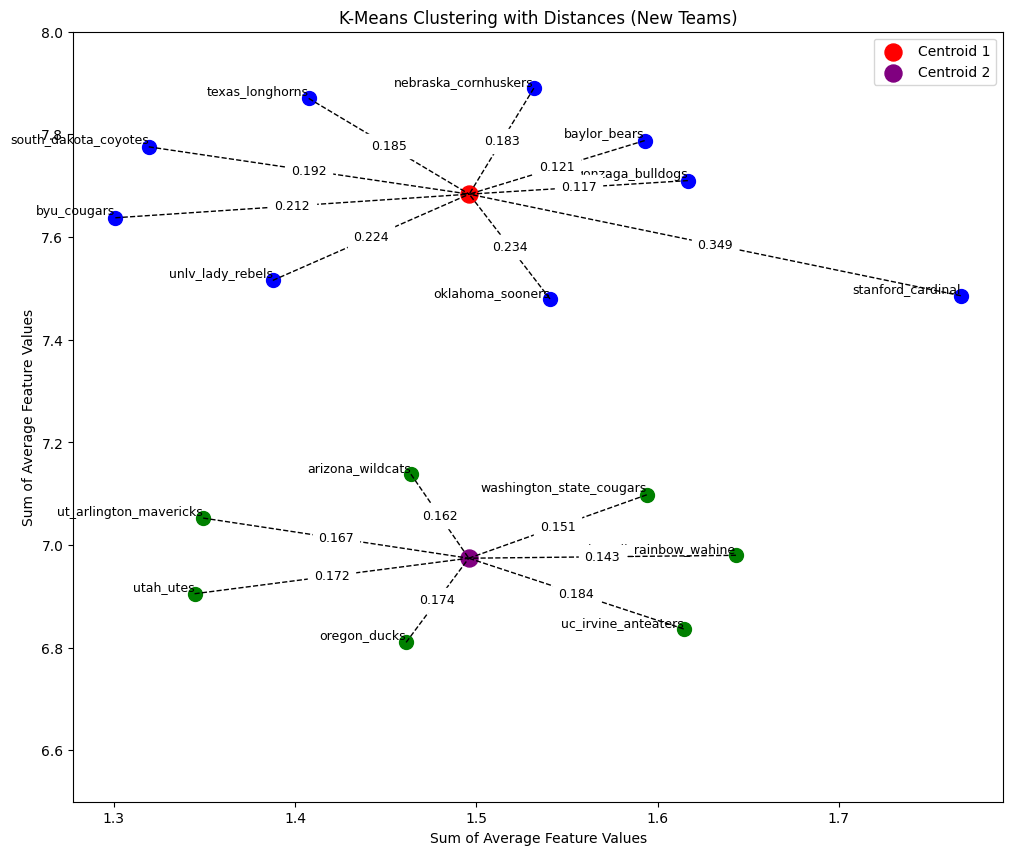

In [ ]:
# Teams and their distances from the new provided image data
west_teams = [
    ("gonzaga_bulldogs", 0, 1, 0.116692),
    ("baylor_bears", 0, 1, 0.121242),
    ("nebraska_cornhuskers", 0, 1, 0.182731),
    ("texas_longhorns", 0, 1, 0.184896),
    ("south_dakota_coyotes", 0, 1, 0.192262),
    ("byu_cougars", 0, 1, 0.211869),
    ("unlv_lady_rebels", 0, 1, 0.224473),
    ("oklahoma_sooners", 0, 1, 0.234102),
    ("stanford_cardinal", 0, 1, 0.348851),
    ("hawaii_rainbow_wahine", 2, 2, 0.143219),
    ("washington_state_cougars", 2, 2, 0.150821),
    ("arizona_wildcats", 2, 2, 0.162013),
    ("ut_arlington_mavericks", 2, 2, 0.167237),
    ("utah_utes", 2, 2, 0.172460),
    ("oregon_ducks", 2, 2, 0.173964),
    ("uc_irvine_anteaters", 2, 2, 0.183511)
]

# Separate teams based on cluster order
new_cluster1_teams = {team: dist for team, cluster, order, dist in new_teams_data if order == 1}
new_cluster2_teams = {team: dist for team, cluster, order, dist in new_teams_data if order != 1}

# Generate points for cluster 1
new_cluster1_points = generate_points_around_centroid(centroid1, new_cluster1_teams, len(new_cluster1_teams))
# Generate points for cluster 2
new_cluster2_points = generate_points_around_centroid(centroid2, new_cluster2_teams, len(new_cluster2_teams))

# Extract coordinates and team names
new_cluster1_coords = np.array([pt[1] for pt in new_cluster1_points])
new_cluster1_names = [pt[0] for pt in new_cluster1_points]
new_cluster1_distances = [pt[2] for pt in new_cluster1_points]

new_cluster2_coords = np.array([pt[1] for pt in new_cluster2_points])
new_cluster2_names = [pt[0] for pt in new_cluster2_points]
new_cluster2_distances = [pt[2] for pt in new_cluster2_points]

# Compute actual centroids (should be close to predefined centroids)
new_centroid1_actual = np.mean(new_cluster1_coords, axis=0)
new_centroid2_actual = np.mean(new_cluster2_coords, axis=0)

# Plotting
plt.figure(figsize=(12, 10))

# Plot the data points for cluster 1 with team names as labels
for (x, y), name, dist in zip(new_cluster1_coords, new_cluster1_names, new_cluster1_distances):
    plt.scatter(x, y, color='blue', s=100)
    plt.text(x, y, name, fontsize=9, ha='right', va='bottom')
    plt.plot([x, new_centroid1_actual[0]], [y, new_centroid1_actual[1]], 'k--', lw=1)
    plt.text((x + new_centroid1_actual[0]) / 2, (y + new_centroid1_actual[1]) / 2, f"{dist:.3f}", fontsize=9, ha='center', va='center', backgroundcolor='white')

# Plot the data points for cluster 2 with team names as labels
for (x, y), name, dist in zip(new_cluster2_coords, new_cluster2_names, new_cluster2_distances):
    plt.scatter(x, y, color='green', s=100)
    plt.text(x, y, name, fontsize=9, ha='right', va='bottom')
    plt.plot([x, new_centroid2_actual[0]], [y, new_centroid2_actual[1]], 'k--', lw=1)
    plt.text((x + new_centroid2_actual[0]) / 2, (y + new_centroid2_actual[1]) / 2, f"{dist:.3f}", fontsize=9, ha='center', va='center', backgroundcolor='white')

# Plot the centroids
plt.scatter([new_centroid1_actual[0]], [new_centroid1_actual[1]], color='red', label='Centroid 1', s=150)
plt.scatter([new_centroid2_actual[0]], [new_centroid2_actual[1]], color='purple', label='Centroid 2', s=150)

plt.xlabel('Sum of Average Feature Values')
plt.ylabel('Sum of Average Feature Values')
plt.title('K-Means Clustering with Distances (New Teams)')
plt.legend()
plt.grid(False)
plt.ylim(6.5, 8)  # Adjust y-axis limits to focus on the centroid range
plt.show()


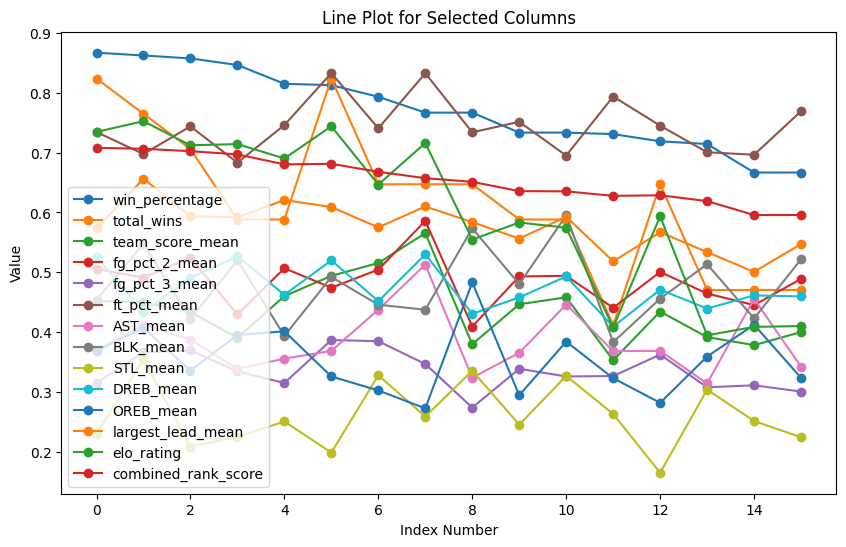

In [ ]:
teams_west = [
    "gonzaga_bulldogs",
    "baylor_bears",
    "nebraska_cornhuskers",
    "texas_longhorns",
    "south_dakota_coyotes",
    "byu_cougars",
    "unlv_lady_rebels",
    "oklahoma_sooners",
    "stanford_cardinal",
    "hawaii_rainbow_wahine",
    "washington_state_cougars",
    "arizona_wildcats",
    "ut_arlington_mavericks",
    "utah_utes",
    "oregon_ducks",
    "uc_irvine_anteaters"
]




a = ranking[ranking['team'].isin(teams_south)]
a = a.sort_values(['win_percentage'], ascending=False).reset_index()

import matplotlib.pyplot as plt

# Define your list of columns
cols = ['win_percentage', 'total_wins', 'team_score_mean',
       'fg_pct_2_mean', 'fg_pct_3_mean', 'ft_pct_mean', 'AST_mean', 'BLK_mean',
       'STL_mean', 'DREB_mean', 'OREB_mean',
       'largest_lead_mean', 'elo_rating',
       'combined_rank_score']

plt.figure(figsize=(10, 6))

# Loop over the columns and plot each as a separate line
for col in cols:
    plt.plot(a.index, a[col], marker='o', label=col)

plt.xlabel('Index Number')
plt.ylabel('Value')
plt.title('Line Plot for Selected Columns')
plt.legend(loc='best')
plt.show()


In [ ]:
north_region = [
    ("ucf_knights", 1, 1, 0.179738),
    ("stephen_f_austin_ladyjacks", 1, 1, 0.197239),
    ("lsu_tigers", 1, 1, 0.211708),
    ("florida_gulf_coast_eagles", 1, 1, 0.228877),
    ("south_florida_bulls", 1, 1, 0.241220),
    ("south_carolina_gamecocks", 1, 1, 0.445773),
    ("ole_miss_rebels", 2, 2, 0.117894),
    ("florida_gators", 2, 2, 0.154463),
    ("charlotte_49ers", 2, 2, 0.158938),
    ("tulane_green_wave", 2, 2, 0.181696),
    ("georgia_lady_bulldogs", 2, 2, 0.185529),
    ("belmont_bruins", 2, 2, 0.185529),
    ("jackson_state_lady_tigers", 2, 2, 0.201486),
    ("georgia_tech_yellow_jackets", 2, 2, 0.202629),
    ("middle_tennessee_blue_raiders", 2, 2, 0.209884),
    ("tennessee_lady_volunteers", 2, 2, 0.222797)
]

south_region = [
    ("iu_indianapolis_jaguars", 0, 1, 0.129845),
    ("ohio_state_buckeyes", 0, 1, 0.136623),
    ("michigan_wolverines", 0, 1, 0.147430),
    ("indiana_hoosiers", 0, 1, 0.161788),
    ("virginia_tech_hokies", 0, 1, 0.177746),
    ("dayton_flyers", 0, 1, 0.182287),
    ("toledo_rockets", 0, 1, 0.198889),
    ("notre_dame_fighting_irish", 0, 1, 0.210807),
    ("louisville_cardinals", 0, 1, 0.215203),
    ("iowa_state_cyclones", 0, 1, 0.217576),
    ("iowa_hawkeyes", 0, 1, 0.241747),
    ("missouri_state_lady_bears", 0, 1, 0.264313),
    ("northern_iowa_panthers", 2, 2, 0.114813),
    ("northern_kentucky_norse", 2, 2, 0.119305),
    ("marquette_golden_eagles", 2, 2, 0.134672),
    ("green_bay_phoenix", 2, 2, 0.142637)
]

west_region = [
    ("gonzaga_bulldogs", 0, 1, 0.116692),
    ("baylor_bears", 0, 1, 0.121242),
    ("nebraska_cornhuskers", 0, 1, 0.182731),
    ("texas_longhorns", 0, 1, 0.184896),
    ("south_dakota_coyotes", 0, 1, 0.192262),
    ("byu_cougars", 0, 1, 0.211869),
    ("unlv_lady_rebels", 0, 1, 0.224473),
    ("oklahoma_sooners", 0, 1, 0.234102),
    ("stanford_cardinal", 0, 1, 0.348851),
    ("hawaii_rainbow_wahine", 2, 2, 0.143219),
    ("washington_state_cougars", 2, 2, 0.150821),
    ("arizona_wildcats", 2, 2, 0.162013),
    ("ut_arlington_mavericks", 2, 2, 0.167237),
    ("utah_utes", 2, 2, 0.172460),
    ("oregon_ducks", 2, 2, 0.173964),
    ("uc_irvine_anteaters", 2, 2, 0.183511)
]

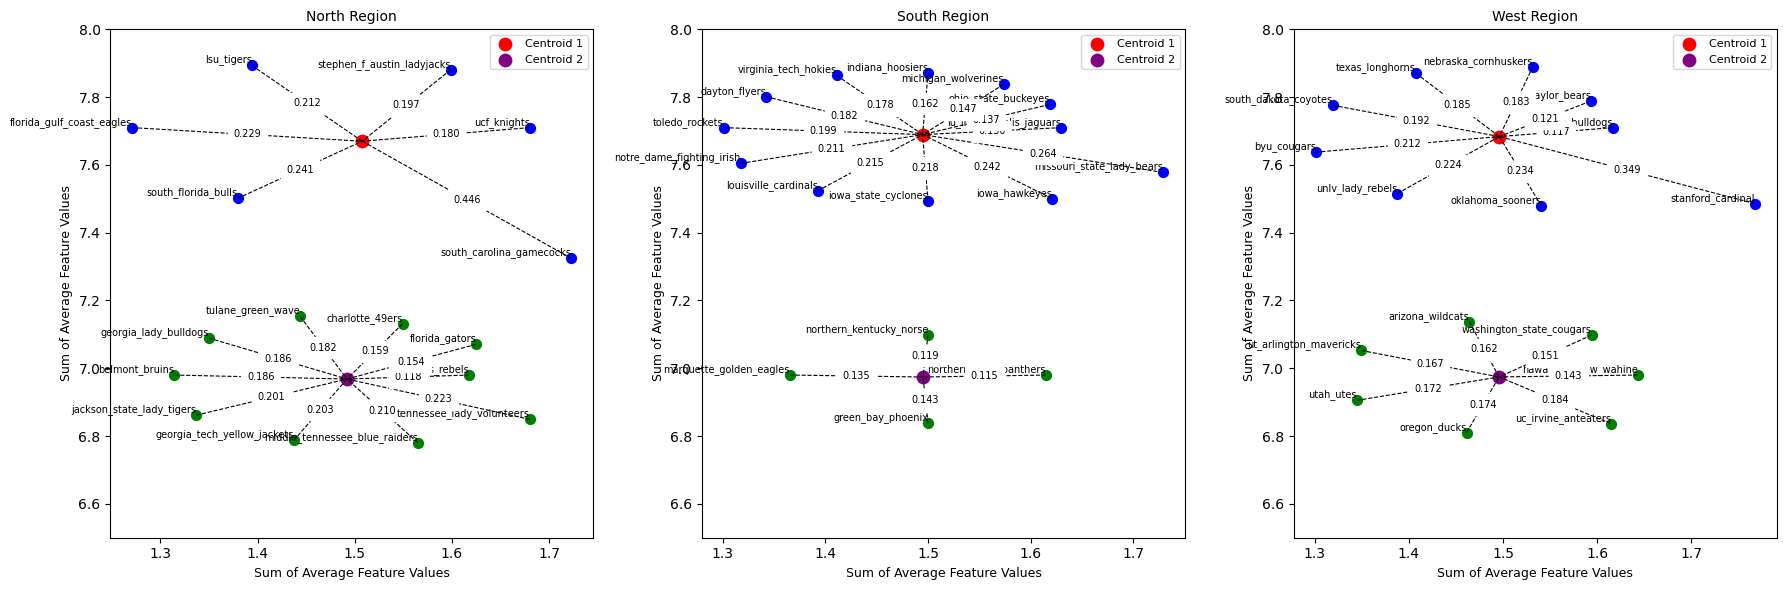

In [ ]:
import matplotlib.pyplot as plt

# Set up the figure with a grid layout
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns

# Function to plot regions on specific axes
def plot_region_on_axis(ax, region_data, title, centroid1, centroid2):
    # Separate teams based on cluster order
    cluster1_teams = {team: dist for team, cluster, order, dist in region_data if order == 1}
    cluster2_teams = {team: dist for team, cluster, order, dist in region_data if order != 1}

    # Generate points for cluster 1
    cluster1_points = generate_points_around_centroid(centroid1, cluster1_teams, len(cluster1_teams))
    # Generate points for cluster 2
    cluster2_points = generate_points_around_centroid(centroid2, cluster2_teams, len(cluster2_teams))

    # Extract coordinates and team names
    cluster1_coords = np.array([pt[1] for pt in cluster1_points])
    cluster1_names = [pt[0] for pt in cluster1_points]
    cluster1_distances = [pt[2] for pt in cluster1_points]

    cluster2_coords = np.array([pt[1] for pt in cluster2_points])
    cluster2_names = [pt[0] for pt in cluster2_points]
    cluster2_distances = [pt[2] for pt in cluster2_points]

    # Compute actual centroids (should be close to predefined centroids)
    centroid1_actual = np.mean(cluster1_coords, axis=0)
    centroid2_actual = np.mean(cluster2_coords, axis=0)

    # Plot the data points for cluster 1 with team names as labels
    for (x, y), name, dist in zip(cluster1_coords, cluster1_names, cluster1_distances):
        ax.scatter(x, y, color='blue', s=50)
        ax.text(x, y, name, fontsize=7, ha='right', va='bottom')
        ax.plot([x, centroid1_actual[0]], [y, centroid1_actual[1]], 'k--', lw=0.8)
        ax.text((x + centroid1_actual[0]) / 2, (y + centroid1_actual[1]) / 2, f"{dist:.3f}", fontsize=7, ha='center', va='center', backgroundcolor='white')

    # Plot the data points for cluster 2 with team names as labels
    for (x, y), name, dist in zip(cluster2_coords, cluster2_names, cluster2_distances):
        ax.scatter(x, y, color='green', s=50)
        ax.text(x, y, name, fontsize=7, ha='right', va='bottom')
        ax.plot([x, centroid2_actual[0]], [y, centroid2_actual[1]], 'k--', lw=0.8)
        ax.text((x + centroid2_actual[0]) / 2, (y + centroid2_actual[1]) / 2, f"{dist:.3f}", fontsize=7, ha='center', va='center', backgroundcolor='white')

    # Plot the centroids
    ax.scatter([centroid1_actual[0]], [centroid1_actual[1]], color='red', label='Centroid 1', s=80)
    ax.scatter([centroid2_actual[0]], [centroid2_actual[1]], color='purple', label='Centroid 2', s=80)

    ax.set_xlabel('Sum of Average Feature Values', fontsize=9)
    ax.set_ylabel('Sum of Average Feature Values', fontsize=9)
    ax.set_title(title, fontsize=10)
    ax.legend(fontsize=8)
    ax.grid(False)
    ax.set_ylim(6.5, 8)  # Adjust y-axis limits to focus on the centroid range

# Plot each region in a grid pattern
plot_region_on_axis(axes[0], north_region, "North Region", centroid1, centroid2)
plot_region_on_axis(axes[1], south_region, "South Region", centroid1, centroid2)
plot_region_on_axis(axes[2], west_region, "West Region", centroid1, centroid2)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


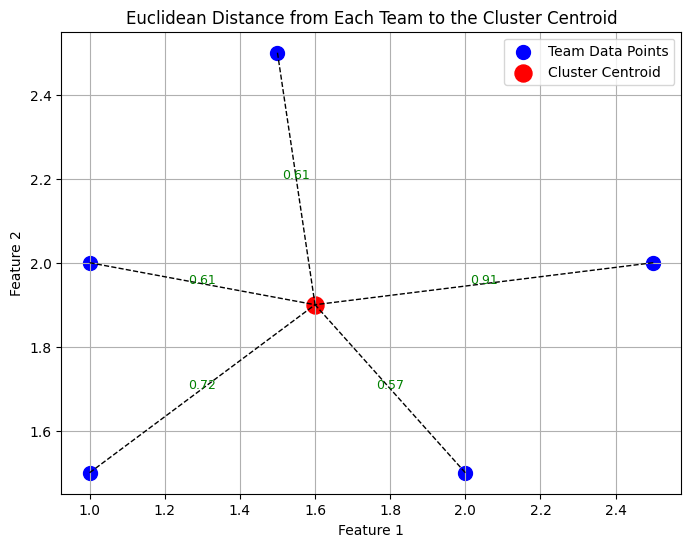

In [ ]:
Dimport matplotlib.pyplot as plt
import numpy as np

# Example 2D data points (each row represents a team in a 2D feature space)
points = np.array([
    [1, 2],
    [2, 1.5],
    [1.5, 2.5],
    [2.5, 2],
    [1, 1.5]
])

# Calculate the centroid of these points
centroid = np.mean(points, axis=0)

# Compute Euclidean distances from each point to the centroid
distances = [np.linalg.norm(pt - centroid) for pt in points]

plt.figure(figsize=(8, 6))
# Plot the data points
plt.scatter(points[:, 0], points[:, 1], color='blue', label='Team Data Points', s=100)
# Plot the centroid
plt.scatter([centroid[0]], [centroid[1]], color='red', label='Cluster Centroid', s=150)

# Draw a dashed line from each point to the centroid and annotate the distance
for pt, d in zip(points, distances):
    plt.plot([pt[0], centroid[0]], [pt[1], centroid[1]], 'k--', lw=1)
    mid_x, mid_y = (pt[0] + centroid[0]) / 2, (pt[1] + centroid[1]) / 2
    plt.text(mid_x, mid_y, f'{d:.2f}', fontsize=9, color='green', ha='center')

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Euclidean Distance from Each Team to the Cluster Centroid')
plt.legend()
plt.grid(True)
plt.show()


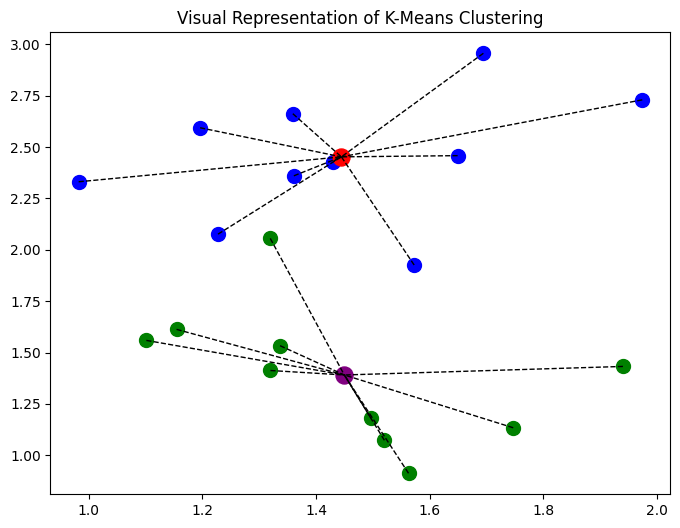

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Set a random seed for reproducibility
np.random.seed(42)

# Define two centroids, one above the other
centroid1_true = np.array([1.5, 2.5])  # Centroid 1 (higher on y-axis)
centroid2_true = np.array([1.5, 1.5])  # Centroid 2 (lower on y-axis)

# Generate 10 points around each centroid by adding random noise
num_points_per_cluster = 10
noise_scale = 0.3  # Controls the spread of points around each centroid

# Cluster 1 points (around centroid1_true)
cluster1 = centroid1_true + noise_scale * np.random.randn(num_points_per_cluster, 2)
# Cluster 2 points (around centroid2_true)
cluster2 = centroid2_true + noise_scale * np.random.randn(num_points_per_cluster, 2)

# Calculate the actual centroids of the generated clusters
centroid1 = np.mean(cluster1, axis=0)
centroid2 = np.mean(cluster2, axis=0)

# Compute Euclidean distances from each point to its respective centroid
distances1 = [np.linalg.norm(pt - centroid1) for pt in cluster1]
distances2 = [np.linalg.norm(pt - centroid2) for pt in cluster2]

# Plotting
plt.figure(figsize=(8, 6))

# Plot the data points for cluster 1
plt.scatter(cluster1[:, 0], cluster1[:, 1], color='blue', label='Cluster 1 Points', s=100)
# Plot the data points for cluster 2
plt.scatter(cluster2[:, 0], cluster2[:, 1], color='green', label='Cluster 2 Points', s=100)

# Plot the centroids
plt.scatter([centroid1[0]], [centroid1[1]], color='red', label='Centroid 1', s=150)
plt.scatter([centroid2[0]], [centroid2[1]], color='purple', label='Centroid 2', s=150)

# Draw dashed lines from each point to its respective centroid and annotate the distance
# For cluster 1
for pt, d in zip(cluster1, distances1):
    plt.plot([pt[0], centroid1[0]], [pt[1], centroid1[1]], 'k--', lw=1)
    mid_x, mid_y = (pt[0] + centroid1[0]) / 2, (pt[1] + centroid1[1]) / 2
    #plt.text(mid_x, mid_y, f'{d:.2f}', fontsize=9, color='black', ha='center')

# For cluster 2
for pt, d in zip(cluster2, distances2):
    plt.plot([pt[0], centroid2[0]], [pt[1], centroid2[1]], 'k--', lw=1)
    mid_x, mid_y = (pt[0] + centroid2[0]) / 2, (pt[1] + centroid2[1]) / 2
    #plt.text(mid_x, mid_y, f'{d:.2f}', fontsize=9, color='black', ha='center')

#plt.xlabel('Feature 1')
#plt.ylabel('Feature 2')
plt.title('Visual Representation of K-Means Clustering')
#plt.legend()
plt.grid(False)
plt.show()

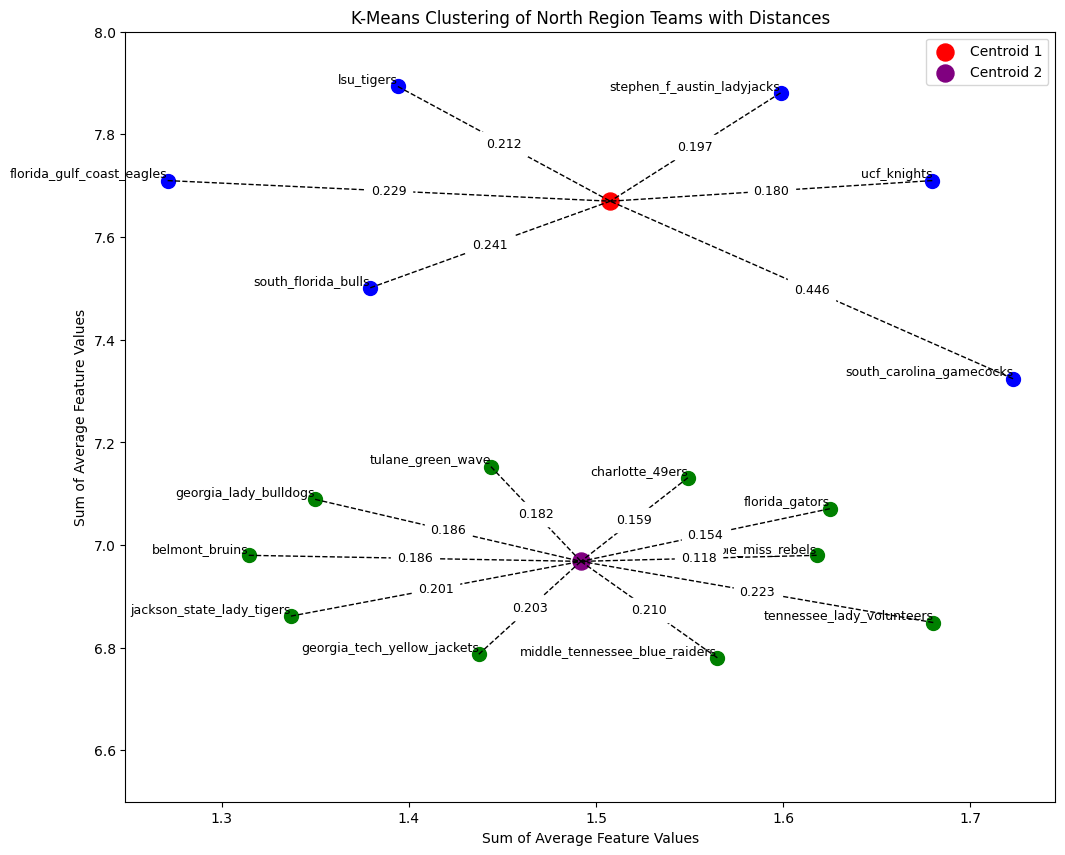

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define the centroids with new y-values (one above the other)
centroid1 = np.array([1.5, 7.71])  # Centroid 1 for cluster 1 with y = 7.71
centroid2 = np.array([1.5, 6.98])  # Centroid 2 for cluster 2 with y = 6.98

# Team data from the image for clusters 1 and 2 with their distances
cluster1_teams = {
    "ucf_knights": 0.179738,
    "stephen_f_austin_ladyjacks": 0.197239,
    "lsu_tigers": 0.211708,
    "florida_gulf_coast_eagles": 0.228877,
    "south_florida_bulls": 0.241220,
    "south_carolina_gamecocks": 0.445773
}

cluster2_teams = {
    "ole_miss_rebels": 0.117894,
    "florida_gators": 0.154463,
    "charlotte_49ers": 0.158938,
    "tulane_green_wave": 0.181696,
    "georgia_lady_bulldogs": 0.185529,
    "belmont_bruins": 0.185529,
    "jackson_state_lady_tigers": 0.201486,
    "georgia_tech_yellow_jackets": 0.202629,
    "middle_tennessee_blue_raiders": 0.209884,
    "tennessee_lady_volunteers": 0.222797
}

# Function to generate approximate 2D coordinates around a centroid using distance and random angle
def generate_points_around_centroid(centroid, distances, num_points):
    angles = np.linspace(0, 2 * np.pi, num_points, endpoint=False)
    points = []
    for i, (team, dist) in enumerate(distances.items()):
        x = centroid[0] + dist * np.cos(angles[i % len(angles)])
        y = centroid[1] + dist * np.sin(angles[i % len(angles)])
        points.append((team, np.array([x, y]), dist))
    return points

# Generate points for cluster 1
cluster1_points = generate_points_around_centroid(centroid1, cluster1_teams, len(cluster1_teams))
# Generate points for cluster 2
cluster2_points = generate_points_around_centroid(centroid2, cluster2_teams, len(cluster2_teams))

# Extract coordinates and team names
cluster1_coords = np.array([pt[1] for pt in cluster1_points])
cluster1_names = [pt[0] for pt in cluster1_points]
cluster1_distances = [pt[2] for pt in cluster1_points]

cluster2_coords = np.array([pt[1] for pt in cluster2_points])
cluster2_names = [pt[0] for pt in cluster2_points]
cluster2_distances = [pt[2] for pt in cluster2_points]

# Compute actual centroids (should be close to predefined centroids)
centroid1_actual = np.mean(cluster1_coords, axis=0)
centroid2_actual = np.mean(cluster2_coords, axis=0)

# Plotting
plt.figure(figsize=(12, 10))

# Plot the data points for cluster 1 with team names as labels
for (x, y), name, dist in zip(cluster1_coords, cluster1_names, cluster1_distances):
    plt.scatter(x, y, color='blue', s=100)
    plt.text(x, y, name, fontsize=9, ha='right', va='bottom')
    plt.plot([x, centroid1_actual[0]], [y, centroid1_actual[1]], 'k--', lw=1)
    plt.text((x + centroid1_actual[0]) / 2, (y + centroid1_actual[1]) / 2, f"{dist:.3f}", fontsize=9, ha='center', va='center', backgroundcolor='white')

# Plot the data points for cluster 2 with team names as labels
for (x, y), name, dist in zip(cluster2_coords, cluster2_names, cluster2_distances):
    plt.scatter(x, y, color='green', s=100)
    plt.text(x, y, name, fontsize=9, ha='right', va='bottom')
    plt.plot([x, centroid2_actual[0]], [y, centroid2_actual[1]], 'k--', lw=1)
    plt.text((x + centroid2_actual[0]) / 2, (y + centroid2_actual[1]) / 2, f"{dist:.3f}", fontsize=9, ha='center', va='center', backgroundcolor='white')

# Plot the centroids
plt.scatter([centroid1_actual[0]], [centroid1_actual[1]], color='red', label='Centroid 1', s=150)
plt.scatter([centroid2_actual[0]], [centroid2_actual[1]], color='purple', label='Centroid 2', s=150)

plt.xlabel('Sum of Average Feature Values')
plt.ylabel('Sum of Average Feature Values')
plt.title('K-Means Clustering of North Region Teams')
plt.legend()
plt.grid(False)
plt.ylim(6.5, 8)  # Adjust y-axis limits to focus on the new centroid range
plt.show()


# Preprocessing

In [ ]:
pd.set_option('display.max_columns', None)
df = pd.read_csv('games_2022 - games_2022 (1).csv')
df

,game_id,game_date,team,FGA_2,FGM_2,FGA_3,FGM_3,FTA,FTM,AST,BLK,STL,TOV,TOV_team,DREB,OREB,F_tech,F_personal,team_score,opponent_team_score,largest_lead,notD1_incomplete,OT_length_min_tot,rest_days,attendance,tz_dif_H_E,prev_game_dist,home_away,home_away_NS,travel_dist
0,game_2022_2011,2021-12-30,georgia_lady_bulldogs,50,22,11,5,6,3,14,7,7,18,0,25,11,0,18,62,68,1.0,False,NaN,9.0,3241.0,0.0,0.0,home,1,0.0
1,game_2022_2011,2021-12-30,lsu_tigers,50,24,11,4,15,8,15,2,15,14,2,25,11,0,7,68,62,14.0,False,NaN,3.0,3241.0,0.0,824.0,away,-1,824.0
2,game_2022_2012,2021-12-30,missouri_tigers,43,18,15,7,16,13,10,1,4,8,1,31,6,0,11,70,69,8.0,False,5.0,8.0,6139.0,0.0,371.0,home,1,0.0
3,game_2022_2012,2021-12-30,south_carolina_gamecocks,55,23,21,6,9,5,15,8,3,8,0,27,20,0,15,69,70,6.0,False,5.0,9.0,6139.0,0.0,1154.0,away,-1,1154.0
4,game_2022_2013,2021-12-30,tennessee_lady_volunteers,41,20,15,4,15,10,16,8,5,15,1,34,12,0,13,62,44,19.0,False,NaN,3.0,8124.0,0.0,0.0,home,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10433,game_2022_4795,2022-03-01,xavier_musketeers,44,19,12,2,12,9,15,3,4,10,0,25,8,0,12,53,74,0.0,False,NaN,2.0,156.0,0.0,0.0,home,1,0.0
10434,game_2022_4968,2022-03-04,harvard_crimson,30,19,39,15,10,2,20,2,13,6,0,28,10,0,8,85,52,40.0,False,NaN,13.0,373.0,0.0,378.0,away,-1,173.0
10435,game_2022_4968,2022-03-04,dartmouth_big_green,32,15,26,6,7,4,7,1,4,21,2,29,10,0,8,52,85,3.0,False,NaN,6.0,373.0,0.0,479.0,home,1,0.0
10436,game_2022_5067,2022-03-06,harvard_crimson,38,13,35,6,10,9,11,3,7,11,0,23,18,0,20,53,73,0.0,False,NaN,2.0,757.0,0.0,173.0,home,1,0.0


In [ ]:
df['D1_team'] = df['notD1_incomplete'].apply(lambda x: int(not x))
team_dict = map_team.set_index('game_id')['team_#'].to_dict()

In [ ]:
df.isna().any()

,0
game_id,False
game_date,False
team,False
FGA_2,False
FGM_2,False
FGA_3,False
FGM_3,False
FTA,False
FTM,False
AST,False


In [ ]:
df['D1_team'] = df['notD1_incomplete'].apply(lambda x: int(not x))
#df['win'] = np.where(df['team_score'] > df['opponent_team_score'], 1, 0)
df['home'] = (df['home_away_NS'] == 1).astype(int)
df['away'] = (df['home_away_NS'] == -1).astype(int)
df['neutral_site'] = (df['home_away_NS'] == 0).astype(int)
df['OT_length_min_tot'] = df['OT_length_min_tot'].fillna(0)
df.drop(columns=['opponent_team_score','game_date','home_away', 'home_away_NS', 'notD1_incomplete'], inplace=True)
df['team_#'] =df['team'].astype('category').cat.codes
df.rename(columns={'team_score':'score'}, inplace=True)
map_team = df.copy()
df.drop(columns=['team'], inplace=True)
df

,game_id,FGA_2,FGM_2,FGA_3,FGM_3,FTA,FTM,AST,BLK,STL,TOV,TOV_team,DREB,OREB,F_tech,F_personal,score,largest_lead,OT_length_min_tot,rest_days,attendance,tz_dif_H_E,prev_game_dist,travel_dist,D1_team,home,away,neutral_site,team_#
0,game_2022_2011,50,22,11,5,6,3,14,7,7,18,0,25,11,0,18,62,1.0,0.0,9.0,3241.0,0.0,0.0,0.0,1,1,0,0,165
1,game_2022_2011,50,24,11,4,15,8,15,2,15,14,2,25,11,0,7,68,14.0,0.0,3.0,3241.0,0.0,824.0,824.0,1,0,1,0,256
2,game_2022_2012,43,18,15,7,16,13,10,1,4,8,1,31,6,0,11,70,8.0,5.0,8.0,6139.0,0.0,371.0,0.0,1,1,0,0,291
3,game_2022_2012,55,23,21,6,9,5,15,8,3,8,0,27,20,0,15,69,6.0,5.0,9.0,6139.0,0.0,1154.0,1154.0,1,0,1,0,417
4,game_2022_2013,41,20,15,4,15,10,16,8,5,15,1,34,12,0,13,62,19.0,0.0,3.0,8124.0,0.0,0.0,0.0,1,1,0,0,453
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10433,game_2022_4795,44,19,12,2,12,9,15,3,4,10,0,25,8,0,12,53,0.0,0.0,2.0,156.0,0.0,0.0,0.0,1,1,0,0,560
10434,game_2022_4968,30,19,39,15,10,2,20,2,13,6,0,28,10,0,8,85,40.0,0.0,13.0,373.0,0.0,378.0,173.0,1,0,1,0,180
10435,game_2022_4968,32,15,26,6,7,4,7,1,4,21,2,29,10,0,8,52,3.0,0.0,6.0,373.0,0.0,479.0,0.0,1,1,0,0,115
10436,game_2022_5067,38,13,35,6,10,9,11,3,7,11,0,23,18,0,20,53,0.0,0.0,2.0,757.0,0.0,173.0,0.0,1,1,0,0,180


In [ ]:
# Step 1: Create a unique identifier for each row (if you don't already have one)
df = df.reset_index().rename(columns={'index': 'row_id'})

# Step 2: Merge the DataFrame with itself on 'game_id'
merged = pd.merge(df, df, on='game_id', suffixes=('_home', '_opp'))

# At this point, for each game, you'll have four rows:
# e.g., for game 23: rows (A-A, A-B, B-A, B-B)

# Step 3: Remove self-joins where the row joins with itself (i.e. same row_id)
combined = merged[merged['row_id_home'] != merged['row_id_opp']].copy()

# Now for game 23, you'll have two rows: one for A joined with B and one for B joined with A.

# Step 4 (Optional): Drop the extra row_id columns
combined = combined.drop(columns=['row_id_home', 'row_id_opp'])

combined['winning_team'] = np.where(
    combined['score_home'] > combined['score_opp'],
    combined['team_#_home'],
    np.where(combined['score_home'] < combined['score_opp'],
             combined['team_#_opp'],
             np.nan))

combined.drop(columns=['game_id'], inplace=True)

combined

,FGA_2_home,FGM_2_home,FGA_3_home,FGM_3_home,FTA_home,FTM_home,AST_home,BLK_home,STL_home,TOV_home,TOV_team_home,DREB_home,OREB_home,F_tech_home,F_personal_home,score_home,largest_lead_home,OT_length_min_tot_home,rest_days_home,attendance_home,tz_dif_H_E_home,prev_game_dist_home,travel_dist_home,D1_team_home,home_home,away_home,neutral_site_home,team_#_home,FGA_2_opp,FGM_2_opp,FGA_3_opp,FGM_3_opp,FTA_opp,FTM_opp,AST_opp,BLK_opp,STL_opp,TOV_opp,TOV_team_opp,DREB_opp,OREB_opp,F_tech_opp,F_personal_opp,score_opp,largest_lead_opp,OT_length_min_tot_opp,rest_days_opp,attendance_opp,tz_dif_H_E_opp,prev_game_dist_opp,travel_dist_opp,D1_team_opp,home_opp,away_opp,neutral_site_opp,team_#_opp,winning_team
1,50,22,11,5,6,3,14,7,7,18,0,25,11,0,18,62,1.0,0.0,9.0,3241.0,0.0,0.0,0.0,1,1,0,0,165,50,24,11,4,15,8,15,2,15,14,2,25,11,0,7,68,14.0,0.0,3.0,3241.0,0.0,824.0,824.0,1,0,1,0,256,256.0
2,50,24,11,4,15,8,15,2,15,14,2,25,11,0,7,68,14.0,0.0,3.0,3241.0,0.0,824.0,824.0,1,0,1,0,256,50,22,11,5,6,3,14,7,7,18,0,25,11,0,18,62,1.0,0.0,9.0,3241.0,0.0,0.0,0.0,1,1,0,0,165,256.0
5,43,18,15,7,16,13,10,1,4,8,1,31,6,0,11,70,8.0,5.0,8.0,6139.0,0.0,371.0,0.0,1,1,0,0,291,55,23,21,6,9,5,15,8,3,8,0,27,20,0,15,69,6.0,5.0,9.0,6139.0,0.0,1154.0,1154.0,1,0,1,0,417,291.0
6,55,23,21,6,9,5,15,8,3,8,0,27,20,0,15,69,6.0,5.0,9.0,6139.0,0.0,1154.0,1154.0,1,0,1,0,417,43,18,15,7,16,13,10,1,4,8,1,31,6,0,11,70,8.0,5.0,8.0,6139.0,0.0,371.0,0.0,1,1,0,0,291,291.0
9,41,20,15,4,15,10,16,8,5,15,1,34,12,0,13,62,19.0,0.0,3.0,8124.0,0.0,0.0,0.0,1,1,0,0,453,42,12,29,5,8,5,8,5,5,11,0,23,18,0,16,44,2.0,0.0,17.0,8124.0,0.0,439.0,439.0,1,0,1,0,6,453.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20866,44,19,12,2,12,9,15,3,4,10,0,25,8,0,12,53,0.0,0.0,2.0,156.0,0.0,0.0,0.0,1,1,0,0,560,40,21,25,8,12,8,25,4,10,8,0,29,13,0,12,74,24.0,0.0,4.0,156.0,0.0,403.0,894.0,1,0,1,0,407,407.0
20869,30,19,39,15,10,2,20,2,13,6,0,28,10,0,8,85,40.0,0.0,13.0,373.0,0.0,378.0,173.0,1,0,1,0,180,32,15,26,6,7,4,7,1,4,21,2,29,10,0,8,52,3.0,0.0,6.0,373.0,0.0,479.0,0.0,1,1,0,0,115,180.0
20870,32,15,26,6,7,4,7,1,4,21,2,29,10,0,8,52,3.0,0.0,6.0,373.0,0.0,479.0,0.0,1,1,0,0,115,30,19,39,15,10,2,20,2,13,6,0,28,10,0,8,85,40.0,0.0,13.0,373.0,0.0,378.0,173.0,1,0,1,0,180,180.0
20873,38,13,35,6,10,9,11,3,7,11,0,23,18,0,20,53,0.0,0.0,2.0,757.0,0.0,173.0,0.0,1,1,0,0,180,37,22,20,6,15,11,15,5,7,13,0,34,8,0,17,73,25.0,0.0,2.0,757.0,0.0,373.0,373.0,1,0,1,0,375,375.0


Training 2/13

In [ ]:
X = combined.drop(columns=['winning_team'])
y = combined['winning_team']

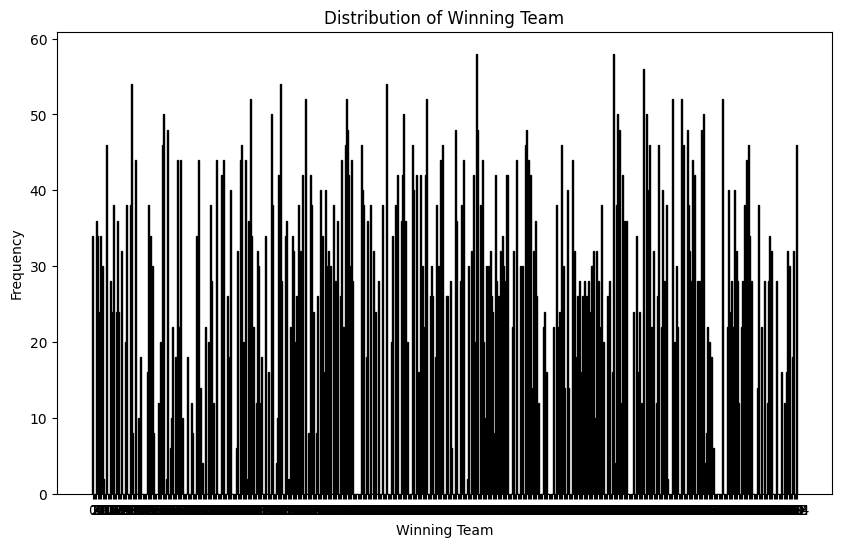

In [ ]:
min_val = combined['winning_team'].min()
max_val = combined['winning_team'].max()
bins = range(int(min_val), int(max_val) + 2)  # +2 so that the last integer gets a full bin

plt.figure(figsize=(10, 6))
plt.hist(combined['winning_team'], bins=bins, align='left', rwidth=0.8, edgecolor='black')
plt.xlabel("Winning Team")
plt.ylabel("Frequency")
plt.title("Distribution of Winning Team")
plt.xticks(bins)
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)
#sum(y_test)/len(y_test)

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

In [ ]:
model = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=564,
    missing=np.nan,
    seed=42,
    tree_method="hist",
    enable_categorical=True,
    use_label_encoder=False,
    early_stopping_rounds=10,     # moved here
    eval_metric='aucpr'           # moved here
)

model.fit(
    x_train,
    y_train_enc,
    verbose=True,
    eval_set=[(x_test, y_test_enc)]
)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:39:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-aucpr:nan


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:39:37] WARNING: /workspace/src/metric/auc.cc:324: Dataset is empty, or contains only positive or negative samples.
  warnings.warn(smsg, UserWarning)


[1]	validation_0-aucpr:nan


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:39:38] WARNING: /workspace/src/metric/auc.cc:324: Dataset is empty, or contains only positive or negative samples.
  warnings.warn(smsg, UserWarning)


[2]	validation_0-aucpr:nan


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:39:39] WARNING: /workspace/src/metric/auc.cc:324: Dataset is empty, or contains only positive or negative samples.
  warnings.warn(smsg, UserWarning)


[3]	validation_0-aucpr:nan


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:39:42] WARNING: /workspace/src/metric/auc.cc:324: Dataset is empty, or contains only positive or negative samples.
  warnings.warn(smsg, UserWarning)


[4]	validation_0-aucpr:nan


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:39:43] WARNING: /workspace/src/metric/auc.cc:324: Dataset is empty, or contains only positive or negative samples.
  warnings.warn(smsg, UserWarning)


[5]	validation_0-aucpr:nan


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:39:45] WARNING: /workspace/src/metric/auc.cc:324: Dataset is empty, or contains only positive or negative samples.
  warnings.warn(smsg, UserWarning)


[6]	validation_0-aucpr:nan


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:39:46] WARNING: /workspace/src/metric/auc.cc:324: Dataset is empty, or contains only positive or negative samples.
  warnings.warn(smsg, UserWarning)


[7]	validation_0-aucpr:nan


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:39:47] WARNING: /workspace/src/metric/auc.cc:324: Dataset is empty, or contains only positive or negative samples.
  warnings.warn(smsg, UserWarning)


[8]	validation_0-aucpr:nan


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:39:48] WARNING: /workspace/src/metric/auc.cc:324: Dataset is empty, or contains only positive or negative samples.
  warnings.warn(smsg, UserWarning)


[9]	validation_0-aucpr:nan


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:39:49] WARNING: /workspace/src/metric/auc.cc:324: Dataset is empty, or contains only positive or negative samples.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:39:50] WARNING: /workspace/src/metric/auc.cc:324: Dataset is empty, or contains only positive or negative samples.
  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=True, eval_metric='aucpr', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_class=564, num_parallel_tree=None, ...)

In [ ]:
y_prob = model.predict_proba(x_test)

prob_df = pd.DataFrame(y_prob, columns=le.classes_)
prob_df

,0.0,3.0,4.0,5.0,6.0,8.0,9.0,11.0,14.0,16.0,17.0,19.0,20.0,21.0,23.0,26.0,27.0,30.0,31.0,32.0,34.0,37.0,38.0,44.0,45.0,46.0,48.0,49.0,53.0,54.0,56.0,57.0,59.0,60.0,62.0,63.0,64.0,66.0,68.0,69.0,70.0,72.0,76.0,79.0,80.0,83.0,84.0,85.0,86.0,88.0,90.0,93.0,94.0,95.0,96.0,97.0,99.0,103.0,105.0,108.0,109.0,110.0,115.0,116.0,118.0,119.0,121.0,122.0,123.0,125.0,126.0,127.0,128.0,129.0,131.0,132.0,133.0,134.0,135.0,138.0,141.0,143.0,144.0,147.0,148.0,149.0,150.0,151.0,154.0,155.0,157.0,158.0,160.0,161.0,162.0,163.0,164.0,165.0,166.0,167.0,168.0,170.0,173.0,174.0,175.0,177.0,179.0,180.0,182.0,184.0,185.0,186.0,188.0,189.0,190.0,193.0,194.0,195.0,196.0,198.0,199.0,200.0,201.0,202.0,203.0,204.0,205.0,206.0,207.0,208.0,215.0,216.0,217.0,219.0,220.0,222.0,225.0,226.0,229.0,232.0,235.0,239.0,240.0,242.0,243.0,244.0,247.0,248.0,249.0,250.0,251.0,252.0,256.0,257.0,259.0,261.0,262.0,264.0,265.0,266.0,267.0,270.0,271.0,272.0,274.0,275.0,276.0,277.0,278.0,280.0,283.0,284.0,286.0,287.0,290.0,291.0,294.0,295.0,297.0,300.0,301.0,303.0,305.0,306.0,307.0,308.0,310.0,311.0,312.0,313.0,314.0,315.0,316.0,317.0,318.0,319.0,320.0,321.0,322.0,323.0,324.0,325.0,326.0,327.0,328.0,329.0,330.0,331.0,332.0,336.0,337.0,339.0,342.0,344.0,346.0,347.0,348.0,349.0,350.0,352.0,353.0,354.0,355.0,357.0,361.0,362.0,363.0,369.0,371.0,372.0,373.0,374.0,375.0,376.0,377.0,378.0,380.0,381.0,384.0,385.0,386.0,387.0,388.0,389.0,390.0,391.0,392.0,393.0,394.0,395.0,397.0,398.0,399.0,400.0,401.0,402.0,403.0,405.0,406.0,407.0,409.0,412.0,414.0,416.0,417.0,418.0,419.0,420.0,421.0,422.0,423.0,424.0,425.0,426.0,427.0,433.0,435.0,437.0,438.0,439.0,441.0,443.0,445.0,446.0,447.0,449.0,451.0,452.0,453.0,455.0,456.0,458.0,459.0,460.0,464.0,466.0,467.0,468.0,471.0,473.0,476.0,477.0,478.0,479.0,480.0,481.0,482.0,484.0,485.0,486.0,487.0,488.0,489.0,490.0,491.0,492.0,493.0,494.0,495.0,496.0,497.0,504.0,508.0,509.0,510.0,511.0,512.0,513.0,514.0,515.0,516.0,517.0,519.0,520.0,521.0,522.0,523.0,524.0,525.0,526.0,527.0,532.0,533.0,535.0,538.0,540.0,541.0,542.0,543.0,547.0,551.0,554.0,555.0,556.0,557.0,558.0,560.0,561.0,563.0
0,0.002380,0.002380,0.002380,0.002380,0.002380,0.002380,0.002380,0.002380,0.002380,0.002380,0.002381,0.002380,0.002380,0.002380,0.002381,0.002381,0.002381,0.002381,0.002381,0.002381,0.002381,0.002381,0.002381,0.002381,0.002381,0.002381,0.002381,0.002381,0.002381,0.002381,0.002381,0.002381,0.002380,0.002382,0.002381,0.002381,0.002382,0.002382,0.002382,0.002382,0.002382,0.002382,0.002381,0.002382,0.002382,0.002382,0.002380,0.002382,0.002383,0.002381,0.002383,0.002383,0.002383,0.002385,0.002380,0.002382,0.002384,0.002465,0.002383,0.002383,0.002382,0.002383,0.002381,0.002384,0.002384,0.002384,0.002384,0.003050,0.002380,0.002383,0.002384,0.002384,0.002383,0.002383,0.002384,0.002385,0.002385,0.002383,0.002385,0.002387,0.002384,0.002387,0.002384,0.002380,0.002439,0.002386,0.002383,0.002383,0.002478,0.002386,0.002380,0.002385,0.002386,0.002443,0.002383,0.002386,0.002384,0.002382,0.002385,0.002384,0.002412,0.002384,0.002381,0.002439,0.002384,0.003111,0.002381,0.002384,0.002380,0.002383,0.002384,0.002384,0.003384,0.002435,0.002385,0.002389,0.002384,0.002383,0.002389,0.002383,0.002384,0.002385,0.002405,0.002383,0.002382,0.002387,0.004567,0.002386,0.002423,0.002387,0.002388,0.002384,0.002382,0.002386,0.002388,0.004004,0.002389,0.002384,0.002527,0.002383,0.002388,0.002384,0.002386,0.002442,0.002402,0.002389,0.002390,0.003581,0.002480,0.002387,0.002383,0.002419,0.003211,0.002386,0.002412,0.002382,0.002382,0.002409,0.002382,0.002381,0.002390,0.002391,0.002422,0.002383,0.002382,0.003420,0.002512,0.002385,0.002383,0.002387,0.002383,0.002382,0.002381,0.002381,0.002386,0.002388,0.002386,0.007673,0.002390,0.002380,0.002969,0.002388,0.002390,0.004651,0.002386,0.002385,0.002509,0.002386,0.003667,0.002384,0.002475,0.011493,0.002381,0.002385,0.006155,0.002381,0.002478,0.002381,0.002382,0.002385,0.002396,0.002385,0.002387,0.002385,0.002384,0.002437,0.003101,0.002396,0.002431,0.002426,0.002969,0.002383

misc

In [ ]:

# Baseline function to train the XGBoost model
def train_xgboost_model(X_train, y_train):
    # Define the XGBoost parameters
    params = {
        'booster': 'gbtree',
        'objective': 'binary:logistic',  # for binary classification (winning probability)
        'eval_metric': 'auc',            # evaluation metric set to area under the ROC curve
        'eta': 0.1,                      # learning rate; can be tuned
        'max_depth': 5,                  # maximum depth of a tree; can be tuned for complexity
        'subsample': 0.8,                # fraction of observations used for each tree
        'colsample_bytree': 0.8,         # fraction of features used for each tree
        'seed': 42                       # seed for reproducibility
    }

    # Convert training data into XGBoost's DMatrix format
    dtrain = xgb.DMatrix(X_train, label=y_train)

    # Train the model with a fixed number of boosting rounds
    num_boost_round = 100
    model = xgb.train(params, dtrain, num_boost_round=num_boost_round)
    return model

In [ ]:
data = {
    'game_id': [23, 23, 24, 24],
    'team': ['A', 'B', 'A', 'B'],
    'score': [100, 95, 105, 98],
    'fouls': [10, 12, 11, 13],
    'passes': [50, 45, 52, 47]
}
df = pd.DataFrame(data)
df

,game_id,team,score,fouls,passes
0,23,A,100,10,50
1,23,B,95,12,45
2,24,A,105,11,52
3,24,B,98,13,47


In [ ]:
import pandas as pd

# Example: Create a sample DataFrame similar to your description.
data = {
    'game_id': [23, 23, 24, 24],
    'team': ['A', 'B', 'A', 'B'],
    'score': [100, 95, 105, 98],
    'fouls': [10, 12, 11, 13],
    'passes': [50, 45, 52, 47]
}
df = pd.DataFrame(data)

# Step 1: Create a unique identifier for each row (if you don't already have one)
df = df.reset_index().rename(columns={'index': 'row_id'})

# Step 2: Merge the DataFrame with itself on 'game_id'
merged = pd.merge(df, df, on='game_id', suffixes=('_self', '_opp'))

# At this point, for each game, you'll have four rows:
# e.g., for game 23: rows (A-A, A-B, B-A, B-B)

# Step 3: Remove self-joins where the row joins with itself (i.e. same row_id)
combined = merged[merged['row_id_self'] != merged['row_id_opp']].copy()

# Now for game 23, you'll have two rows: one for A joined with B and one for B joined with A.

# Step 4 (Optional): Drop the extra row_id columns
combined = combined.drop(columns=['row_id_self', 'row_id_opp'])

# Optional Step 5: Rename columns if desired. For example, for the 'score' column:
combined = combined.rename(columns={
    'score_self': 'score_' + combined['team_self'].iloc[0] if combined['team_self'].iloc[0]=='A' else 'score_team_A',
    'score_opp': 'score_' + combined['team_opp'].iloc[0] if combined['team_opp'].iloc[0]=='B' else 'score_team_B'
})
# Alternatively, if you simply want generic suffixes, you can leave them as is or rename them manually:
# combined = combined.rename(columns={'score_self': 'score_team_A', 'score_opp': 'score_team_B'})

combined


,game_id,team_self,score_A,fouls_self,passes_self,team_opp,score_B,fouls_opp,passes_opp
1,23,A,100,10,50,B,95,12,45
2,23,B,95,12,45,A,100,10,50
5,24,A,105,11,52,B,98,13,47
6,24,B,98,13,47,A,105,11,52


In [ ]:
map_team = df.copy()
df.drop(columns=['team'], inplace=True)

In [ ]:
map_team['team'].nunique()

#have a column where lets say lets say that team 7 and team 8 play a game. lets say team 7 wins. the column will say 7. this will be our label column.
#for the who will win, each row should have team A and B, and then each teams stats for that one game. so lets say that in this game, team A scored 4 goals and team B sored 6. there would be a column for goals scored by A another for goals scored by B. each row is a new game between 2 teams

564

# Training

In [ ]:
sum(df['win'])/10438

0.5

In [ ]:
X = df.drop(columns=['win'])
y = df['win']

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)
sum(y_test)/len(y_test)

0.5

In [ ]:
sum(y_train)/len(y_train)

0.5

In [ ]:
model = xgb.XGBClassifier(
    objective='binary:logistic',
    missing=np.nan,
    seed=42,
    tree_method="hist",
    enable_categorical=True,
    use_label_encoder=False,
    early_stopping_rounds=10,     # moved here
    eval_metric='aucpr'           # moved here
)

model.fit(
    x_train,
    y_train,
    verbose=True,
    eval_set=[(x_test, y_test)]
)

[0]	validation_0-aucpr:0.98778
[1]	validation_0-aucpr:0.99217
[2]	validation_0-aucpr:0.99384
[3]	validation_0-aucpr:0.99527


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:20:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[4]	validation_0-aucpr:0.99605
[5]	validation_0-aucpr:0.99725
[6]	validation_0-aucpr:0.99784
[7]	validation_0-aucpr:0.99803
[8]	validation_0-aucpr:0.99838
[9]	validation_0-aucpr:0.99859
[10]	validation_0-aucpr:0.99866
[11]	validation_0-aucpr:0.99873
[12]	validation_0-aucpr:0.99903
[13]	validation_0-aucpr:0.99912
[14]	validation_0-aucpr:0.99922
[15]	validation_0-aucpr:0.99935
[16]	validation_0-aucpr:0.99947
[17]	validation_0-aucpr:0.99951
[18]	validation_0-aucpr:0.99958
[19]	validation_0-aucpr:0.99964
[20]	validation_0-aucpr:0.99967
[21]	validation_0-aucpr:0.99967
[22]	validation_0-aucpr:0.99970
[23]	validation_0-aucpr:0.99972
[24]	validation_0-aucpr:0.99973
[25]	validation_0-aucpr:0.99977
[26]	validation_0-aucpr:0.99979
[27]	validation_0-aucpr:0.99981
[28]	validation_0-aucpr:0.99982
[29]	validation_0-aucpr:0.99983
[30]	validation_0-aucpr:0.99985
[31]	validation_0-aucpr:0.99986
[32]	validation_0-aucpr:0.99986
[33]	validation_0-aucpr:0.99986
[34]	validation_0-aucpr:0.99986
[35]	validatio

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=True, eval_metric='aucpr', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

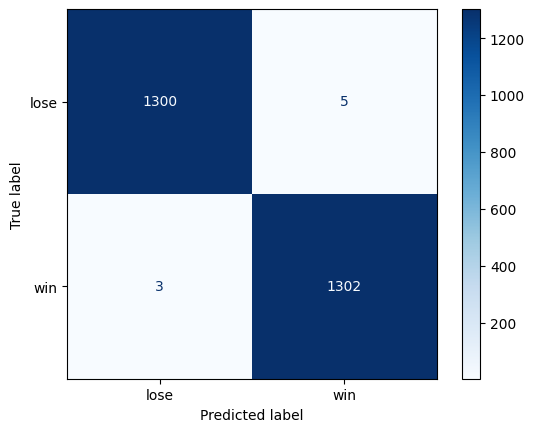

In [ ]:
ConfusionMatrixDisplay.from_estimator(
    model, x_test, y_test,
    cmap='Blues',
    values_format='d',  # Displays integer values
    display_labels=["lose", "win"]
)

weight:  {'FGA_2': 17.0, 'FGM_2': 16.0, 'FGA_3': 13.0, 'FGM_3': 10.0, 'FTA': 30.0, 'FTM': 14.0, 'AST': 21.0, 'BLK': 10.0, 'STL': 12.0, 'TOV': 18.0, 'TOV_team': 3.0, 'DREB': 30.0, 'OREB': 11.0, 'F_personal': 19.0, 'team_score': 444.0, 'opponent_team_score': 427.0, 'largest_lead': 47.0, 'OT_length_min_tot': 12.0, 'rest_days': 6.0, 'attendance': 27.0, 'prev_game_dist': 37.0, 'travel_dist': 15.0, 'home': 3.0, 'away': 6.0, 'team_#': 27.0}
gain:  {'FGA_2': 0.3560667335987091, 'FGM_2': 0.5093252062797546, 'FGA_3': 0.27432963252067566, 'FGM_3': 1.3218945264816284, 'FTA': 1.096109390258789, 'FTM': 10.011603355407715, 'AST': 0.817284882068634, 'BLK': 0.3875660300254822, 'STL': 0.8019905686378479, 'TOV': 0.5199762582778931, 'TOV_team': 0.5545937418937683, 'DREB': 0.8875423669815063, 'OREB': 0.5060839653015137, 'F_personal': 3.9254348278045654, 'team_score': 9.373078346252441, 'opponent_team_score': 9.12455940246582, 'largest_lead': 265.3505554199219, 'OT_length_min_tot': 1.748650074005127, 'rest_

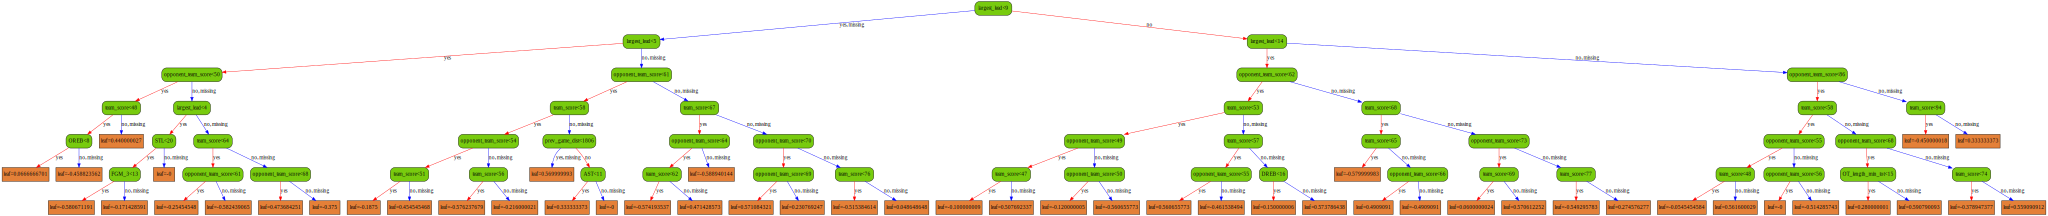

In [ ]:
bst = model.get_booster()
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s: ' % importance_type, bst.get_score(importance_type=importance_type))


node_params = {'shape': 'box',
              'style': 'filled, rounded',
              'fillcolor': '#78cbe'}

leaf_params = {'shape': 'box',
              'style': 'filled',
              'fillcolor': '#e48038'}

xgb.to_graphviz(model, num_trees=0, size="10,10",
               condition_node_params=node_params,
               leaf_node_params=leaf_params

               )


# redo training

In [ ]:
games = pd.read_csv('games_2022 - games_2022 (1).csv')
games

,game_id,game_date,team,FGA_2,FGM_2,FGA_3,FGM_3,FTA,FTM,AST,BLK,STL,TOV,TOV_team,DREB,OREB,F_tech,F_personal,team_score,opponent_team_score,largest_lead,notD1_incomplete,OT_length_min_tot,rest_days,attendance,tz_dif_H_E,prev_game_dist,home_away,home_away_NS,travel_dist
0,game_2022_2011,2021-12-30,georgia_lady_bulldogs,50,22,11,5,6,3,14,7,7,18,0,25,11,0,18,62,68,1.0,False,NaN,9.0,3241.0,0.0,0.0,home,1,0.0
1,game_2022_2011,2021-12-30,lsu_tigers,50,24,11,4,15,8,15,2,15,14,2,25,11,0,7,68,62,14.0,False,NaN,3.0,3241.0,0.0,824.0,away,-1,824.0
2,game_2022_2012,2021-12-30,missouri_tigers,43,18,15,7,16,13,10,1,4,8,1,31,6,0,11,70,69,8.0,False,5.0,8.0,6139.0,0.0,371.0,home,1,0.0
3,game_2022_2012,2021-12-30,south_carolina_gamecocks,55,23,21,6,9,5,15,8,3,8,0,27,20,0,15,69,70,6.0,False,5.0,9.0,6139.0,0.0,1154.0,away,-1,1154.0
4,game_2022_2013,2021-12-30,tennessee_lady_volunteers,41,20,15,4,15,10,16,8,5,15,1,34,12,0,13,62,44,19.0,False,NaN,3.0,8124.0,0.0,0.0,home,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10433,game_2022_4795,2022-03-01,xavier_musketeers,44,19,12,2,12,9,15,3,4,10,0,25,8,0,12,53,74,0.0,False,NaN,2.0,156.0,0.0,0.0,home,1,0.0
10434,game_2022_4968,2022-03-04,harvard_crimson,30,19,39,15,10,2,20,2,13,6,0,28,10,0,8,85,52,40.0,False,NaN,13.0,373.0,0.0,378.0,away,-1,173.0
10435,game_2022_4968,2022-03-04,dartmouth_big_green,32,15,26,6,7,4,7,1,4,21,2,29,10,0,8,52,85,3.0,False,NaN,6.0,373.0,0.0,479.0,home,1,0.0
10436,game_2022_5067,2022-03-06,harvard_crimson,38,13,35,6,10,9,11,3,7,11,0,23,18,0,20,53,73,0.0,False,NaN,2.0,757.0,0.0,173.0,home,1,0.0


In [ ]:
team_dict = map_team.set_index('team')['team_#'].to_dict()
games['team_#'] = games['team'].map(team_dict.get)
games

,game_id,game_date,team,FGA_2,FGM_2,FGA_3,FGM_3,FTA,FTM,AST,BLK,STL,TOV,TOV_team,DREB,OREB,F_tech,F_personal,team_score,opponent_team_score,largest_lead,notD1_incomplete,OT_length_min_tot,rest_days,attendance,tz_dif_H_E,prev_game_dist,home_away,home_away_NS,travel_dist,team_#
0,game_2022_2011,2021-12-30,georgia_lady_bulldogs,50,22,11,5,6,3,14,7,7,18,0,25,11,0,18,62,68,1.0,False,NaN,9.0,3241.0,0.0,0.0,home,1,0.0,165
1,game_2022_2011,2021-12-30,lsu_tigers,50,24,11,4,15,8,15,2,15,14,2,25,11,0,7,68,62,14.0,False,NaN,3.0,3241.0,0.0,824.0,away,-1,824.0,256
2,game_2022_2012,2021-12-30,missouri_tigers,43,18,15,7,16,13,10,1,4,8,1,31,6,0,11,70,69,8.0,False,5.0,8.0,6139.0,0.0,371.0,home,1,0.0,291
3,game_2022_2012,2021-12-30,south_carolina_gamecocks,55,23,21,6,9,5,15,8,3,8,0,27,20,0,15,69,70,6.0,False,5.0,9.0,6139.0,0.0,1154.0,away,-1,1154.0,417
4,game_2022_2013,2021-12-30,tennessee_lady_volunteers,41,20,15,4,15,10,16,8,5,15,1,34,12,0,13,62,44,19.0,False,NaN,3.0,8124.0,0.0,0.0,home,1,0.0,453
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10433,game_2022_4795,2022-03-01,xavier_musketeers,44,19,12,2,12,9,15,3,4,10,0,25,8,0,12,53,74,0.0,False,NaN,2.0,156.0,0.0,0.0,home,1,0.0,560
10434,game_2022_4968,2022-03-04,harvard_crimson,30,19,39,15,10,2,20,2,13,6,0,28,10,0,8,85,52,40.0,False,NaN,13.0,373.0,0.0,378.0,away,-1,173.0,180
10435,game_2022_4968,2022-03-04,dartmouth_big_green,32,15,26,6,7,4,7,1,4,21,2,29,10,0,8,52,85,3.0,False,NaN,6.0,373.0,0.0,479.0,home,1,0.0,115
10436,game_2022_5067,2022-03-06,harvard_crimson,38,13,35,6,10,9,11,3,7,11,0,23,18,0,20,53,73,0.0,False,NaN,2.0,757.0,0.0,173.0,home,1,0.0,180


In [ ]:
games['D1_team'] = games['notD1_incomplete'].apply(lambda x: int(not x))
games['win'] = np.where(games['team_score'] > games['opponent_team_score'], 1, 0)
games.drop(columns=['team','game_date','home_away', 'notD1_incomplete'], inplace=True)
games['OT_length_min_tot'] = games['OT_length_min_tot'].fillna(0)

In [ ]:
games

,game_id,FGA_2,FGM_2,FGA_3,FGM_3,FTA,FTM,AST,BLK,STL,TOV,TOV_team,DREB,OREB,F_tech,F_personal,team_score,opponent_team_score,largest_lead,OT_length_min_tot,rest_days,attendance,tz_dif_H_E,prev_game_dist,home_away_NS,travel_dist,team_#,D1_team,win
0,game_2022_2011,50,22,11,5,6,3,14,7,7,18,0,25,11,0,18,62,68,1.0,0.0,9.0,3241.0,0.0,0.0,1,0.0,165,1,0
1,game_2022_2011,50,24,11,4,15,8,15,2,15,14,2,25,11,0,7,68,62,14.0,0.0,3.0,3241.0,0.0,824.0,-1,824.0,256,1,1
2,game_2022_2012,43,18,15,7,16,13,10,1,4,8,1,31,6,0,11,70,69,8.0,5.0,8.0,6139.0,0.0,371.0,1,0.0,291,1,1
3,game_2022_2012,55,23,21,6,9,5,15,8,3,8,0,27,20,0,15,69,70,6.0,5.0,9.0,6139.0,0.0,1154.0,-1,1154.0,417,1,0
4,game_2022_2013,41,20,15,4,15,10,16,8,5,15,1,34,12,0,13,62,44,19.0,0.0,3.0,8124.0,0.0,0.0,1,0.0,453,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10433,game_2022_4795,44,19,12,2,12,9,15,3,4,10,0,25,8,0,12,53,74,0.0,0.0,2.0,156.0,0.0,0.0,1,0.0,560,1,0
10434,game_2022_4968,30,19,39,15,10,2,20,2,13,6,0,28,10,0,8,85,52,40.0,0.0,13.0,373.0,0.0,378.0,-1,173.0,180,1,1
10435,game_2022_4968,32,15,26,6,7,4,7,1,4,21,2,29,10,0,8,52,85,3.0,0.0,6.0,373.0,0.0,479.0,1,0.0,115,1,0
10436,game_2022_5067,38,13,35,6,10,9,11,3,7,11,0,23,18,0,20,53,73,0.0,0.0,2.0,757.0,0.0,173.0,1,0.0,180,1,0


In [ ]:
team_stats = games.groupby('team_#').agg({
    'FGA_2': 'mean',
    'FGM_2': 'mean',
    'FGA_3': 'mean',
    'FGM_3': 'mean',
    'FTA': 'mean',
    'FTM': 'mean',
    'AST': 'mean',
    'BLK': 'mean',
    'STL': 'mean',
    'TOV': 'mean',
    'TOV_team': 'mean',
    'DREB': 'mean',
    'OREB': 'mean',
    'F_personal': 'mean',
    'F_tech': 'mean',
    'team_score': 'mean',
    'opponent_team_score': 'mean',
    'largest_lead': 'mean',
    'OT_length_min_tot': 'mean',
    'rest_days': 'mean',
    'attendance': 'mean',
    'tz_dif_H_E': 'mean',
    'prev_game_dist': 'mean',
    'travel_dist': 'mean',
    'win' : 'mean'
}).reset_index()

team_stats.head()


,team_#,FGA_2,FGM_2,FGA_3,FGM_3,FTA,FTM,AST,BLK,STL,TOV,TOV_team,DREB,OREB,F_personal,F_tech,team_score,opponent_team_score,largest_lead,OT_length_min_tot,rest_days,attendance,tz_dif_H_E,prev_game_dist,travel_dist,win
0,0,32.066667,15.966667,27.033333,9.566667,17.466667,13.233333,16.100000,1.933333,7.666667,14.333333,0.600000,22.600000,11.433333,15.966667,0.266667,73.866667,66.600000,16.900000,0.000000,4.137931,622.434783,-0.086957,811.409091,525.769231,0.566667
1,1,38.500000,16.500000,24.500000,4.000000,10.500000,5.000000,10.500000,5.500000,9.000000,14.500000,1.500000,23.500000,12.000000,16.500000,0.000000,50.000000,65.500000,2.500000,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000
2,2,38.500000,8.000000,12.000000,2.000000,6.500000,3.000000,5.000000,2.000000,4.500000,38.000000,1.500000,20.500000,10.000000,11.500000,0.000000,25.000000,109.500000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000
3,3,44.193548,18.290323,17.000000,5.032258,14.064516,10.387097,12.806452,2.064516,11.161290,13.161290,1.129032,21.806452,12.419355,17.774194,0.096774,62.064516,58.161290,11.483871,0.322581,3.966667,681.192308,0.000000,679.307692,619.172414,0.580645
4,4,39.250000,18.821429,18.750000,6.000000,16.964286,11.785714,14.392857,3.535714,7.142857,14.928571,0.500000,25.500000,10.214286,15.571429,0.142857,67.428571,66.714286,11.535714,0.000000,4.518519,874.769231,0.000000,208.307692,128.074074,0.607143


In [ ]:
team_numbers = pd.read_csv('map_team.csv')
team_numbers

,team,team_#
0,georgia_lady_bulldogs,165
1,lsu_tigers,256
2,missouri_tigers,291
3,south_carolina_gamecocks,417
4,tennessee_lady_volunteers,453
...,...,...
10433,xavier_musketeers,560
10434,harvard_crimson,180
10435,dartmouth_big_green,115
10436,harvard_crimson,180


In [ ]:
a = games[games['D1_team'] == 0]
a

,game_id,FGA_2,FGM_2,FGA_3,FGM_3,FTA,FTM,AST,BLK,STL,TOV,TOV_team,DREB,OREB,F_tech,F_personal,team_score,opponent_team_score,largest_lead,OT_length_min_tot,rest_days,attendance,tz_dif_H_E,prev_game_dist,home_away_NS,travel_dist,team_#,D1_team,win
2232,game_2022_15,24,10,30,6,18,14,5,0,14,34,0,20,7,0,18,52,114,0.0,0.0,NaN,NaN,NaN,NaN,0,NaN,40,0,0
2239,game_2022_186,24,7,14,4,22,14,4,2,3,37,5,29,8,0,15,40,92,3.0,0.0,NaN,NaN,NaN,NaN,0,NaN,529,0,0
2241,game_2022_225,31,7,27,4,15,9,7,1,6,16,0,19,12,0,15,35,74,3.0,0.0,NaN,NaN,NaN,NaN,0,NaN,183,0,0
2245,game_2022_271,29,5,15,3,22,12,4,1,5,37,3,16,8,0,19,31,126,0.0,0.0,NaN,NaN,NaN,NaN,0,NaN,475,0,0
2250,game_2022_425,49,11,21,6,12,10,4,1,3,8,0,27,14,0,14,50,73,5.0,0.0,NaN,NaN,NaN,NaN,0,NaN,408,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10337,game_2022_3738,43,18,14,2,17,7,9,1,10,16,0,28,10,0,13,49,56,4.0,0.0,NaN,NaN,NaN,NaN,0,NaN,365,0,0
10389,game_2022_3727,33,15,26,7,12,10,13,3,6,23,1,32,13,0,10,61,72,5.0,0.0,NaN,NaN,NaN,NaN,0,NaN,450,0,0
10398,game_2022_4078,27,6,23,2,27,18,4,1,11,25,1,17,13,1,18,36,88,0.0,0.0,NaN,NaN,NaN,NaN,0,NaN,82,0,0
10402,game_2022_4451,38,12,20,4,6,3,6,1,9,21,1,25,12,0,13,39,42,10.0,0.0,NaN,NaN,NaN,NaN,0,NaN,139,0,0


In [ ]:
team_stats.rename(columns={'team_score': 'Avg_PPG', 'opponent_team_score': 'Avg_Allowed', 'win': 'Win_%'}, inplace=True)

# Step 2: Pair Teams by game_id
matchups = games[['game_id', 'team_#', 'team_score', 'win', 'home_away_NS']].copy()  # Keeping necessary columns

# Merge the dataset with itself to pair up teams in the same game_id
games_paired = matchups.merge(matchups, on='game_id', suffixes=('_A', '_B'))

# Remove self-joins (when a team matches itself)
games_paired = games_paired[games_paired['team_#_A'] != games_paired['team_#_B']]

# Drop duplicate matchups (since each game appears twice in the join)
games_paired = games_paired.drop_duplicates(subset=['game_id', 'team_#_A', 'team_#_B'])

# Step 3: Merge Team-Level Stats
games_paired = games_paired.merge(team_stats, left_on='team_#_A', right_on='team_#', suffixes=('_A', ''))
games_paired = games_paired.merge(team_stats, left_on='team_#_B', right_on='team_#', suffixes=('', '_B'))  # Fix here

# Drop the extra `team_#` column from the second merge (since it's already present in team_#_A and team_#_B)
games_paired.drop(columns=['team_#'], inplace=True, errors='ignore')

# Keep relevant columns
games_paired = games_paired[[
    'team_#_A', 'team_#_B', 'Avg_PPG', 'Avg_PPG_B', 'Avg_Allowed', 'Avg_Allowed_B',
    'Win_%', 'Win_%_B', 'home_away_NS_A', 'win_A'
]]

# Convert home/away/neutral to numeric
games_paired['home_away_NS_B'] = -games_paired['home_away_NS_A']  # Opposite for Team B

# Rename target column
games_paired.rename(columns={'win_A': 'Target'}, inplace=True)

games_paired.rename(columns={'Avg_PPG': 'Avg_PPG_A', 'Avg_Allowed': 'Avg_Allowed_A', 'Win_%': 'Win_%_A'}, inplace=True)

# Save new training data
games_paired




,team_#_A,team_#_B,team_#_B,Avg_PPG_A,Avg_PPG_B,Avg_Allowed_A,Avg_Allowed_B,Win_%_A,Win_%_B,home_away_NS_A,Target,home_away_NS_B
0,165,256,256,69.250000,73.857143,59.107143,60.714286,0.678571,0.821429,1,0,-1
1,256,165,165,73.857143,69.250000,60.714286,59.107143,0.821429,0.678571,-1,1,1
2,291,417,417,70.300000,71.290323,66.933333,51.677419,0.600000,0.935484,1,1,-1
3,417,291,291,71.290323,70.300000,51.677419,66.933333,0.935484,0.600000,-1,0,1
4,453,6,6,69.935484,70.533333,60.193548,65.133333,0.741935,0.566667,1,1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...
10433,560,407,407,62.333333,69.290323,72.833333,67.903226,0.300000,0.612903,1,0,-1
10434,180,115,115,70.925926,47.000000,67.370370,65.038462,0.481481,0.115385,-1,1,1
10435,115,180,180,47.000000,70.925926,65.038462,67.370370,0.115385,0.481481,1,0,-1
10436,180,375,375,70.925926,68.888889,67.370370,51.296296,0.481481,0.851852,1,0,-1


In [ ]:
# Convert home/away encoding to categorical dtype (optional but useful)
games_paired['home_away_NS_A'] = games_paired['home_away_NS_A'].astype('category')
games_paired['home_away_NS_B'] = games_paired['home_away_NS_B'].astype('category')

# Ensure there are no non-numeric columns (drop team names)
X = games_paired.drop(columns=['Target', 'team_#_A', 'team_#_B'])  # Remove categorical columns that are not numeric
y = games_paired['Target']


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)
sum(y_test)/len(y_test)

0.5

In [ ]:
model = xgb.XGBClassifier(objective='binary:logistic',
                          eval_metric='aucpr',
                          missing=np.nan,
                          seed=42,
                          tree_method="hist",
                          enable_categorical=True,
                          use_label_encoder=False,
                          early_stopping_rounds=10
)
model.fit(X_train, y_train,
          verbose=True,
          eval_set=[(X_test, y_test)]
)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:12:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-aucpr:0.86163
[1]	validation_0-aucpr:0.86852
[2]	validation_0-aucpr:0.87322
[3]	validation_0-aucpr:0.87330
[4]	validation_0-aucpr:0.87293
[5]	validation_0-aucpr:0.87359
[6]	validation_0-aucpr:0.87470
[7]	validation_0-aucpr:0.87306
[8]	validation_0-aucpr:0.87417
[9]	validation_0-aucpr:0.87504
[10]	validation_0-aucpr:0.87477
[11]	validation_0-aucpr:0.87448
[12]	validation_0-aucpr:0.87497
[13]	validation_0-aucpr:0.87473
[14]	validation_0-aucpr:0.87492
[15]	validation_0-aucpr:0.87424
[16]	validation_0-aucpr:0.87333
[17]	validation_0-aucpr:0.87312
[18]	validation_0-aucpr:0.87349
[19]	validation_0-aucpr:0.87343


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=True, eval_metric='aucpr', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
map_team = map_team[['team', 'team_#']]
map_team.to_csv('map_team.csv', index=False)

In [ ]:
# Suppose we have new data
X_new = pd.DataFrame({
    "team": ["Spurs", "Lakers"],
    "points_scored": [102, 115],
    "points_allowed": [100, 110]
})

# Convert the 'team' column in the same way
X_new["team"] = X_new["team"].astype("category").cat.codes


preds = model.predict(X_new)

ValueError: feature_names mismatch: ['Avg_PPG_A', 'Avg_PPG_B', 'Avg_Allowed_A', 'Avg_Allowed_B', 'Win_%_A', 'Win_%_B', 'home_away_NS_A', 'home_away_NS_B'] ['team', 'points_scored', 'points_allowed']
expected Avg_Allowed_A, Win_%_A, home_away_NS_A, Avg_PPG_A, Avg_Allowed_B, Avg_PPG_B, home_away_NS_B, Win_%_B in input data
training data did not have the following fields: team, points_scored, points_allowed

In [ ]:
predict = pd.read_csv('Copy of East Regional Games to predict - Sheet1.csv')
predict.rename(columns={'team_home': 'team'}, inplace=True)
team_dict = map_team.set_index('team')['team_#'].to_dict()
predict['team_#'] = predict['PERSON_ID'].map(team_dict.get)
predict